In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# VAE Class

In [2]:
class VAE:
    def __init__(self, input_dim, hidden_dims, latent_dim, data_size=1):
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim

        # Encoder weights and biases
        self.encoder_weights = []
        self.encoder_biases = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            # self.encoder_weights.append(np.random.randn(prev_dim, h_dim) * 0.01)
            self.encoder_weights.append(np.random.randn(prev_dim, h_dim) * 0.01)
            self.encoder_biases.append(np.zeros((1, h_dim)))
            prev_dim = h_dim

        # Latent space parameters
        # self.W_mu = np.random.randn(prev_dim, latent_dim) * 0.01
        self.W_mu = np.random.randn(prev_dim, latent_dim) * 0.01
        self.b_mu = np.zeros((1, latent_dim))
        # self.W_logvar = np.random.randn(prev_dim, latent_dim) * 0.01
        self.W_logvar = np.random.randn(prev_dim, latent_dim) * 0.01
        self.b_logvar = np.zeros((1, latent_dim))

        # Decoder weights and biases
        self.decoder_weights = []
        self.decoder_biases = []
        hidden_dims_reverse = list(reversed(hidden_dims))
        prev_dim = latent_dim
        for h_dim in hidden_dims_reverse:
            # self.decoder_weights.append(np.random.randn(prev_dim, h_dim) * 0.01)
            self.decoder_weights.append(np.random.randn(prev_dim, h_dim) * 0.01)
            self.decoder_biases.append(np.zeros((1, h_dim)))
            prev_dim = h_dim

        # Final decoder layer
        self.W_out = np.random.randn(prev_dim, input_dim) * 0.01
        self.b_out = np.zeros((1, input_dim))

    # Activation functions
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self,x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def softplus(self,x):
        return np.log10(1 + np.exp(x))

    def softplus_derivative(self,x):
        return 1 / (1 + np.exp(-x))

    def relu(self,x):
        return np.maximum(0, x)

    def relu_derivative(self,x):
        return (x > 0).astype(float)

    # Loss functions
    def binary_cross_entropy(self,y_pred, y_true):
        return -np.sum(y_true * np.log(y_pred ) + (1 - y_true) * np.log(1 - y_pred))

    def binary_cross_entropy_derivative(self,y_pred, y_true):
        # return (y_pred - y_true) / (y_pred * (1 - y_pred))
        return -y_true /y_pred + (1-y_true)/(1-y_pred)

    def kl_divergence(self,mu, logvar):
        return -0.5 * np.sum(1 + logvar - np.square(mu) - (logvar))

    # Reparameterization trick
    def reparameterize(self,mu, logvar):
        std = np.exp(0.5 * logvar)
        self.eps = np.random.randn(*mu.shape)
        return mu + self.eps * std

    def forward(self, x):
        # Encoder forward pass
        h = x
        encoder_activations = []
        for W, b in zip(self.encoder_weights, self.encoder_biases):
            h = self.relu(np.dot(h, W) + b)
            encoder_activations.append(h)
        if not encoder_activations:
            encoder_activations.append(h)

        # Latent space
        mu = np.dot(h, self.W_mu) + self.b_mu
        logvar = np.dot(h, self.W_logvar) + self.b_logvar
        z = self.reparameterize(mu, self.relu(logvar))

        # Decoder forward pass
        h = z
        decoder_activations = []
        # print(self.decoder_weights, self.decoder_biases)
        for W, b in zip(self.decoder_weights, self.decoder_biases):
            h = self.relu(np.dot(h, W) + b)
            decoder_activations.append(h)
        if not decoder_activations:
            decoder_activations.append(h)
        x_recon = self.sigmoid(np.dot(h, self.W_out) + self.b_out)

        return x_recon, mu, logvar, z, encoder_activations, decoder_activations

    def only_forward(self,x,w_enc, b_enc,w_mu,b_mu, w_var, b_var, w_dec, b_dec):
        # Encoder forward pass
        h = x
        encoder_activations = []
        for W, b in zip(self.encoder_weights, self.encoder_biases):
            h = self.relu(np.dot(h, W) + b)
            encoder_activations.append(h)
        if not encoder_activations:
            encoder_activations.append(h)

        # Latent space
        mu = np.dot(h, self.W_mu) + self.b_mu
        logvar = np.dot(h, self.W_logvar) + self.b_logvar
        z = self.reparameterize(mu, self.relu(logvar))

        # Decoder forward pass
        h = z
        decoder_activations = []
        # print(self.decoder_weights, self.decoder_biases)
        for W, b in zip(self.decoder_weights, self.decoder_biases):
            h = self.relu(np.dot(h, W) + b)
            decoder_activations.append(h)
        if not decoder_activations:
            decoder_activations.append(h)
        x_recon = self.sigmoid(np.dot(h, self.W_out) + self.b_out)

        return x_recon, mu, logvar, z, encoder_activations, decoder_activations

    def backward(self, x, x_recon, mu, logvar, z, encoder_activations, decoder_activations, learning_rate):
        # Gradient of reconstruction loss with respect to x_recon
        d_x_recon = self.binary_cross_entropy_derivative(x_recon, x)

        # Backpropagate through the output layer
        d_h = d_x_recon * (x_recon * (1 - x_recon))  # Sigmoid derivative

        # Update final decoder layer
        self.W_out -= learning_rate * np.matmul(decoder_activations[-1].T, d_h)
        self.b_out -= learning_rate * np.sum(d_h, axis=0, keepdims=True)

        d_h = d_h = np.matmul(d_h, self.W_out.T)

        # Update decoder hidden layers
        for i in reversed(range(len(self.decoder_weights))):
            # d_h = np.dot(d_h, self.decoder_weights[i].T) * (decoder_activations[i] > 0).astype(float)  # ReLU derivative
            self.decoder_weights[i] -= learning_rate * np.matmul(decoder_activations[i - 1].T, d_h) if i > 0 else learning_rate * np.matmul(z.T, d_h)
            self.decoder_biases[i] -= learning_rate * np.sum(d_h, axis=0, keepdims=True)
            d_h = np.matmul(d_h, self.decoder_weights[i].T) * self.relu_derivative(decoder_activations[i-1]) if i>0 else np.matmul(d_h, self.decoder_weights[i].T)

        # Gradients for latent space
        # d_z = np.dot(d_h, self.decoder_weights[0].T)  # Backprop into latent space

        # Backpropagate through the reparameterization trick
        d_mu = d_h
        d_logvar = 0.5 * d_h * self.eps * np.exp(0.5 * logvar)

        # Update latent space weights and biases
        self.W_mu -= learning_rate * np.matmul(encoder_activations[-1].T, d_mu)
        self.b_mu -= learning_rate * np.sum(d_mu, axis=0, keepdims=True)

        self.W_logvar -= learning_rate * np.matmul(encoder_activations[-1].T, d_logvar)
        self.b_logvar -= learning_rate * np.sum(d_logvar, axis=0, keepdims=True)

        # self.W_mu -= learning_rate * (np.dot(encoder_activations[-1].T, d_h) + np.dot(encoder_activations[-1].T, mu))
        # grad_b_mu = (np.sum(d_h, axis=1, keepdims=True) + mu)
        # for mu_elem in grad_b_mu:
        #     self.b_mu -= learning_rate * mu_elem

        # self.W_logvar -= learning_rate * np.dot(encoder_activations[-1].T,(0.5 * d_h * self.eps * np.exp(0.5 * logvar)))
        # self.b_logvar -= learning_rate * (np.sum(0.5 * d_h * self.eps * np.exp(0.5 * logvar), axis=0, keepdims=True))

        # d_mu = d_h + mu
        # d_logvar = 0.5 * d_h * self.eps * np.exp(0.5 * logvar) * self.relu_derivative(logvar)

        # Update encoder layers
        d_h = np.matmul(d_mu, self.W_mu.T) + np.matmul(d_logvar, self.W_logvar.T)
        for i in reversed(range(len(self.encoder_weights))):
            self.encoder_weights[i] -= learning_rate * np.matmul(encoder_activations[i - 1].T, d_h) if i > 0 else learning_rate * np.matmul(x.T, d_h)
            self.encoder_biases[i] -= learning_rate * np.sum(d_h, axis=0, keepdims=True)
            d_h = np.matmul(d_h, self.encoder_weights[i].T) * self.relu_derivative(encoder_activations[i-1]) if i>0 else np.matmul(d_h, self.encoder_weights[i].T)

    def train(self, x, valid_data, epochs, learning_rate, doTest = True):
        history_loss = []
        preTrain_data = x.copy()
        print(f'Data to train: {x}')
        print(f'Valid Data: {valid_data}')

        # if len(valid_data.shape) == 3:
        for epoch in range(epochs):
            total_loss = 0
            kl_loss = 0
            recon_loss = 0
            # for idx,sample in enumerate(x):  # Iterate through each column
            #     # print(f'Iter {idx}\tTraining of data {sample} based on data {valid_data[idx]}')
            #     curr_data = sample.reshape(1, -1)
            #     # print(f'Reshaped data: {curr_data}')
            #     x_recon, mu, logvar, z, encoder_activations, decoder_activations = self.forward(curr_data)
            #     # print(f'Current reconstruction: {x_recon}')

            #     # Compute losses
            #     recon_loss_sample = self.binary_cross_entropy(x_recon, valid_data[idx])
            #     kl_loss_sample = self.kl_divergence(mu, logvar)
            #     loss = recon_loss_sample + kl_loss_sample

            #     # Backward pass
            #     self.backward(valid_data[idx], x_recon, mu, logvar, z, encoder_activations, decoder_activations, learning_rate)

            #     # Accumulate losses
            #     total_loss += loss
            #     kl_loss += kl_loss_sample
            #     recon_loss += recon_loss_sample

            # print(f'Iter {idx}\tTraining of data {sample} based on data {valid_data[idx]}')
            curr_data = x.copy()
            # print(f'Reshaped data: {curr_data}')
            x_recon, mu, logvar, z, encoder_activations, decoder_activations = self.forward(curr_data)
            # print(f'Current reconstruction: {x_recon}')

            # Compute losses
            recon_loss_sample = self.binary_cross_entropy(x_recon, valid_data)
            kl_loss_sample = self.kl_divergence(mu, logvar)
            beta = 0.1
            loss = recon_loss_sample + beta * kl_loss_sample

            # Backward pass
            self.backward(valid_data, x_recon, mu, logvar, z, encoder_activations, decoder_activations, learning_rate)

            # Accumulate losses
            total_loss += loss
            kl_loss += kl_loss_sample
            recon_loss += recon_loss_sample

            # Loss history
            curr_avg_loss = total_loss/x.shape[0]
            history_loss.append(curr_avg_loss)

            # Check error and break
            if total_loss < (2**(-8)):
                break

            # Print epoch details
            if (epoch + 1) % 1 == 0 or epoch == 0:
                # print(f"Epoch {epoch + 1}/{epochs} - Total Loss: {total_loss:.4f}, Recon Loss: {recon_loss:.4f}, KL Loss: {kl_loss:.4f}, Average Loss: {curr_avg_loss:.4f}",end='\n')
                print(f"Epoch {epoch + 1}/{epochs} - Total Loss: {total_loss:.4f}, Recon Loss: {recon_loss:.4f}, KL Loss: {kl_loss:.4f}",end='\n')
        # else:
        #     for epoch in range(epochs):
        #         total_loss = 0
        #         kl_loss = 0
        #         recon_loss = 0
        #         for idx,sample in enumerate(x):  # Iterate through each column
        #             # print(f'Iter {idx}\tTraining of data {sample} based on data {valid_data[idx]}')
        #             curr_data = sample.reshape(1, -1)
        #             # print(f'Reshaped data: {x}')
        #             x_recon, mu, logvar, z, encoder_activations, decoder_activations = self.forward(curr_data)

        #             # Compute losses
        #             recon_loss_sample = self.binary_cross_entropy(x_recon, valid_data)
        #             kl_loss_sample = self.kl_divergence(mu, logvar)
        #             loss = recon_loss_sample + kl_loss_sample

        #             # Backward pass
        #             self.backward(valid_data, x_recon, mu, logvar, z, encoder_activations, decoder_activations, learning_rate)

        #             # Accumulate losses
        #             total_loss += loss
        #             kl_loss += kl_loss_sample
        #             recon_loss += recon_loss_sample

        #         # Loss history
        #         curr_avg_loss = total_loss/x.shape[0]
        #         history_loss.append(curr_avg_loss)

        #         # Check error and break
        #         if total_loss < (2**(-8)):
        #             break

        #         # Print epoch details
        #         if (epoch + 1) % 1 == 0 or epoch == 0:
        #             # print(f"Epoch {epoch + 1}/{epochs} - Total Loss: {total_loss:.4f}, Recon Loss: {recon_loss:.4f}, KL Loss: {kl_loss:.4f}, Average Loss: {curr_avg_loss:.4f}",end='\n')
        #             print(f"Epoch {epoch + 1}/{epochs} - Total Loss: {total_loss:.4f}, Recon Loss: {recon_loss:.4f}, KL Loss: {kl_loss:.4f}",end='\n')

        print(f'This Data: {x}')
        print(f'Has finished trained based on the following Valid Data:')
        check_valid_data = []
        for i in valid_data: print(i); check_valid_data.append(i)
        if doTest:
            # Evaluate: Reconstruct the input data
            reconstructed = []
            latent_val = []
            for x in preTrain_data:
                x = x.reshape(1, -1)
                x_recon, _, _, curr_latent, _, _ = self.forward(x)
                reconstructed.append(x_recon)
                latent_val.append(curr_latent)
            reconstructed = np.vstack(reconstructed)

            print(f"\nOriginal Data: (Shape: {preTrain_data.shape})")
            print(preTrain_data)

            print(f"\nReconstructed Data: (Shape: {reconstructed.shape})")
            print(np.round(reconstructed))  # Rounded for binary output

            # mtrx_true_data = np.tile(valid_data[0], (x.shape[0],1))
            # if ((np.round(reconstructed)==mtrx_true_data).all()): print('[INFO] Reconstruction success')
            # else: print('[ERROR] Reconstruction Failed')

            if ((np.round(reconstructed)==check_valid_data).all()): print('[INFO] Reconstruction success')
            else: print('[ERROR] Reconstruction Failed')

            plt.figure(figsize=(10,9))
            plt.plot(history_loss,label="Loss History")
            plt.legend()
            plt.xlabel("Epoch")
            plt.ylabel("Error")
            plt.title('Total History over Epochs')
            plt.show()

        # After training, return latent value
        return latent_val



    def get_train_param(self):
        return self.encoder_weights,self.encoder_biases, self.W_mu,self.b_mu, self.W_logvar,self.b_logvar, self.decoder_weights,self.decoder_biases, self.W_out, self.b_out

# Testing VAE on X and O data

Data to train: [[1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [0. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 0. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 0. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 0. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 1. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 0. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 0. 0. 1. 0. 1.]]
Valid Data: [[1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]]
Epoch 1/1000 - Total Loss: 74.3217, Recon Loss: 74.9217, KL Loss: -5.9997
Epoch 2/1000 - Total Loss: 73.5679, Recon Loss: 74.1678, KL Loss: -5.9997
Epoch 3/1000 - Total Loss: 72.7287, Recon Loss: 73.3286, KL Loss: -5.9996
Epoch 4/1000 - Total Loss: 72

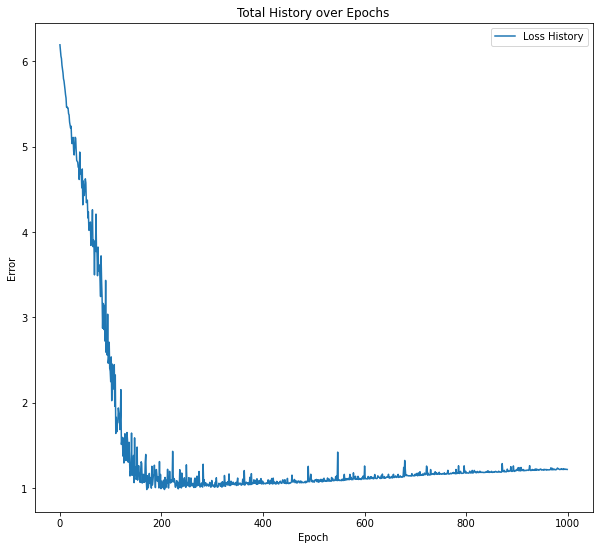

In [3]:
input_dim = 9  # Number of input features
latent_dim = 1  # Number of latent dimensions
hidden_dims = []

vae = VAE(input_dim=input_dim, hidden_dims=hidden_dims, latent_dim=latent_dim)

# Create dataset
testData = np.zeros((12,9))
testData[0,:] = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]]).reshape(1,9).flatten()
testData[1,:] = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 1]]).reshape(1,9).flatten()
testData[2,:] = np.array([[1, 0, 1], [1, 0, 1], [1, 1, 1]]).reshape(1,9).flatten()
testData[3,:] = np.array([[1, 1, 0], [1, 0, 1], [1, 1, 1]]).reshape(1,9).flatten()
testData[4,:] = np.array([[1, 1, 1], [0, 0, 1], [1, 1, 1]]).reshape(1,9).flatten()
testData[5,:] = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]).reshape(1,9).flatten()

testData[6,:] = np.array([[1, 0, 1], [0, 1, 0], [1, 0, 1]]).reshape(1,9).flatten()
testData[7,:] = np.array([[0, 0, 1], [0, 1, 0], [1, 0, 1]]).reshape(1,9).flatten()
testData[8,:] = np.array([[1, 1, 1], [0, 1, 0], [1, 0, 1]]).reshape(1,9).flatten()
testData[9,:] = np.array([[1, 0, 0], [0, 1, 0], [1, 0, 1]]).reshape(1,9).flatten()
testData[10,:] = np.array([[1, 0, 1], [1, 1, 0], [1, 0, 1]]).reshape(1,9).flatten()
testData[11,:] = np.array([[1, 0, 1], [0, 0, 0], [1, 0, 1]]).reshape(1,9).flatten()

valid_data = np.zeros((12,9))
valid_data[:6,:] = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]]).reshape(1,9).flatten()
valid_data[6:,:] = np.array([[1, 0, 1], [0, 1, 0], [1, 0, 1]]).reshape(1,9).flatten()

# data = testData

# label_train_simple = np.concatenate((valid_data1, valid_data2), axis=0)
# data_train_simple = np.concatenate((data, data), axis=0)

# Train the VAE
epochs = 1000
learning_rate = 0.005
latent_val = vae.train(testData, valid_data, epochs, learning_rate)

# Wafermap Data Learning

## Reading Dataset of Wafermap

In [4]:
import cv2
df=pd.read_pickle("WM811K.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   dieSize         811457 non-null  float64
 1   failureType     811457 non-null  object 
 2   lotName         811457 non-null  object 
 3   trainTestLabel  811457 non-null  object 
 4   waferIndex      811457 non-null  float64
 5   waferMap        811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [5]:
# Function to scale up image
def upscale_images(np_arr, max_shape):
    return cv2.resize(np_arr, (max_shape[1],max_shape[0]), interpolation=cv2.INTER_CUBIC)

def sizeLimit_df(old_df, max_shape, doLimit=False):
  if doLimit: return old_df[old_df['waferMap'].apply(lambda x: x.shape[0] <= max_shape[0] and x.shape[1] <= max_shape[1])]
  else: return old_df

# Function to display wafer
def print_image(np_arr):
    if np.max(np_arr) == 2: cmap = mcolors.ListedColormap(['black', 'grey', 'white'])
    else: cmap = mcolors.ListedColormap(['black', 'grey'])
    # Create an image of the array
    plt.imshow(np_arr, cmap=cmap, interpolation='nearest')

    # Optionally, remove axis labels
    plt.axis('off')

    # Show the plot
    plt.show()

## Get Training Data

In [6]:
max_shape = (40,40)
target_shape = (32,32)
train_max_row = 20 # Maximum data for training

strClass_trainTestLaebl_df = df[df['trainTestLabel'].apply(lambda x: isinstance(x, str))]
limited_df = sizeLimit_df(strClass_trainTestLaebl_df,max_shape,True)
training_df = limited_df[limited_df['trainTestLabel'] == 'Training']

bad_wafer_df = training_df[ (training_df['failureType'] != 'none')]
good_wafer_df = training_df[ (training_df['failureType'] == 'none')]

# Function to filter very bad data
def filter_condition(np_arr, wafer_type):
    count_0 = np.sum(np_arr == 0)  # Count occurrences of 1
    count_1 = np.sum(np_arr == 1)  # Count occurrences of 1
    count_2 = np.sum(np_arr == 2)  # Count occurrences of 2
    if wafer_type == 'bad': return (count_2 > 0.05 * count_1) & (count_0 < count_1)  # Check if count of 2 is less than 20% of count of 1
    else: return (count_2 < 0.05 * count_1) & (count_0 < count_1)  # Check if count of 2 is less than 20% of count of 1


bad_wafer_df = bad_wafer_df[bad_wafer_df['waferMap'].apply(lambda x: filter_condition(x, 'bad'))]
good_wafer_df = good_wafer_df[good_wafer_df['waferMap'].apply(lambda x: filter_condition(x, 'good'))]

# Label data for bad wafer
maxSize_bad_wafer = bad_wafer_df[(bad_wafer_df['waferMap'].apply(lambda x: x.shape == (35,36)))]
mtrx_label_bad_wafer = np.stack(maxSize_bad_wafer['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
mtrx_label_bad_wafer[(mtrx_label_bad_wafer == 1) | (mtrx_label_bad_wafer > 2)] = 2
base_bad_valid = np.array(mtrx_label_bad_wafer[0])
label_bad_wafer = np.tile(base_bad_valid,(train_max_row,1))

# Label data for good wafer
maxSize_good_wafer = good_wafer_df[(good_wafer_df['waferMap'].apply(lambda x: x.shape == (35,37)))]
mtrx_label_good_wafer = np.stack(maxSize_good_wafer['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
mtrx_label_good_wafer[mtrx_label_good_wafer >1] = 1
base_good_valid = np.array(mtrx_label_good_wafer[0])
label_good_wafer = np.tile(base_good_valid,(train_max_row,1))

# Maximum Data for Training
# print(bad_wafer_df.shape, good_wafer_df.shape)
max_training_good = good_wafer_df.shape[0]
max_training_bad = bad_wafer_df.shape[0]
print(max_training_good, max_training_bad)
bad_wafer_df = bad_wafer_df[:train_max_row]
good_wafer_df = good_wafer_df[:train_max_row]

# Scale all image to asme dimension then flatten it to single row
data_bad_wafer = np.stack(bad_wafer_df['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
data_bad_wafer[data_bad_wafer>2] = 2

data_good_wafer = np.stack(good_wafer_df['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
data_good_wafer[data_good_wafer>2] = 2

label_train = np.concatenate((label_bad_wafer, label_good_wafer), axis=0)
data_train = np.concatenate((data_bad_wafer, data_good_wafer), axis=0)

label_train = np.where(label_train == 0, 0 , np.where(label_train == 1, 0.5, 1))
data_train = np.where(data_train == 0, 0 , np.where(data_train == 1, 0.5, 1))

print(label_train.shape)
print(data_train.shape)


106 8003
(40, 1024)
(40, 1024)


In [7]:
# label_train = np.concatenate((label_good_wafer,label_bad_wafer), axis=0)
# data_train = np.concatenate((data_good_wafer, data_bad_wafer), axis=0)
label_train = np.concatenate((label_bad_wafer, label_good_wafer), axis=0)
data_train = np.concatenate((data_bad_wafer, data_good_wafer), axis=0)

label_train = np.where(label_train == 0, 0 , np.where(label_train == 1, 0.5, 1))
data_train = np.where(data_train == 0, 0 , np.where(data_train == 1, 0.5, 1))

print(label_train.shape)
print(data_train.shape)

(40, 1024)
(40, 1024)


#### Extra Testing

Unique Shapes (from smallest to largest):
Shape: (26, 26), Area: 676, Count: 20


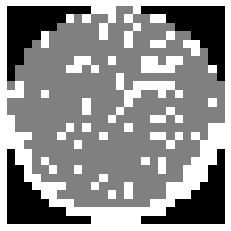

In [8]:
# Extract shapes and count occurrences
def filter_condition(np_arr):
    count_0 = np.sum(np_arr == 0)  # Count occurrences of 1
    count_1 = np.sum(np_arr == 1)  # Count occurrences of 1
    count_2 = np.sum(np_arr == 2)  # Count occurrences of 2
    return (count_2 > 0.05 * count_1) & (count_0 < count_1)  # Check if count of 2 is less than 20% of count of 1
filtered_df = bad_wafer_df[bad_wafer_df['waferMap'].apply(filter_condition)]
# filtered_df = bad_wafer_df

shape_counts = filtered_df["waferMap"].apply(lambda img: img.shape).value_counts()

# Sort shapes sequentially (smallest to largest by area, then by dimensions)
sorted_shapes = sorted(shape_counts.items(), key=lambda x: (x[0][0] * x[0][1], x[0][0], x[0][1]))

# Print the unique shapes, their area, and counts
print("Unique Shapes (from smallest to largest):")
for shape, count in sorted_shapes:
    area = shape[0] * shape[1]
    print(f"Shape: {shape}, Area: {area}, Count: {count}")
    temp = bad_wafer_df[(bad_wafer_df['waferMap'].apply(lambda x: x.shape == shape))]
    print_image(temp['waferMap'].iloc[0])

Unique Shapes (from smallest to largest):
Shape: (39, 31), Area: 1209, Count: 1


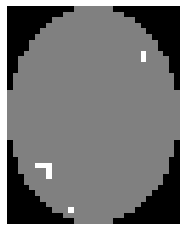

Shape: (35, 37), Area: 1295, Count: 19


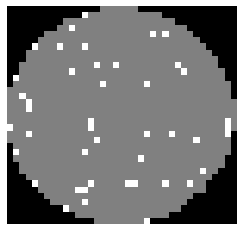

In [9]:
# Extract shapes and count occurrences
def filter_condition(np_arr):
    count_0 = np.sum(np_arr == 0)  # Count occurrences of 1
    count_1 = np.sum(np_arr == 1)  # Count occurrences of 1
    count_2 = np.sum(np_arr == 2)  # Count occurrences of 2
    return (count_2 < 0.05 * count_1) & (count_0 < count_1)  # Check if count of 2 is less than 20% of count of 1
filtered_df = good_wafer_df[good_wafer_df['waferMap'].apply(filter_condition)]

shape_counts = filtered_df["waferMap"].apply(lambda img: img.shape).value_counts()

# Sort shapes sequentially (smallest to largest by area, then by dimensions)
sorted_shapes = sorted(shape_counts.items(), key=lambda x: (x[0][0] * x[0][1], x[0][0], x[0][1]))

# Print the unique shapes, their area, and counts
print("Unique Shapes (from smallest to largest):")
for shape, count in sorted_shapes:
    area = shape[0] * shape[1]
    print(f"Shape: {shape}, Area: {area}, Count: {count}")
    temp = good_wafer_df[(good_wafer_df['waferMap'].apply(lambda x: x.shape == shape))]
    print_image(temp['waferMap'].iloc[0])

## Train Good and Bad Wafer Data

In [10]:
# Initialize the VAE with no hidden layers
input_dim = data_train.shape[1]  # Number of input features
latent_dim = 1  # Number of latent dimensions
hidden_dims = []

vae = VAE(input_dim=input_dim, hidden_dims=hidden_dims, latent_dim=latent_dim)

max_shape = (50,50)
target_shape = (32,32)
train_max_row = 20 # Maximum data for training

strClass_trainTestLaebl_df = df[df['trainTestLabel'].apply(lambda x: isinstance(x, str))]
limited_df = sizeLimit_df(strClass_trainTestLaebl_df,max_shape,True)
training_df = limited_df[limited_df['trainTestLabel'] == 'Training']

bad_wafer_df = training_df[ (training_df['failureType'] != 'none')]
good_wafer_df = training_df[ (training_df['failureType'] == 'none')]

# Function to filter very bad data
def filter_condition(np_arr, wafer_type):
    count_0 = np.sum(np_arr == 0)  # Count occurrences of 1
    count_1 = np.sum(np_arr == 1)  # Count occurrences of 1
    count_2 = np.sum(np_arr == 2)  # Count occurrences of 2
    if wafer_type == 'bad': return (count_2 > 0.9 * count_1) & (count_0 < count_1)  # Check if count of 2 is less than 20% of count of 1
    else: return (count_2 < 0.05 * count_1) & (count_0 < count_1)  # Check if count of 2 is less than 20% of count of 1
    # return True


bad_wafer_df = bad_wafer_df[bad_wafer_df['waferMap'].apply(lambda x: filter_condition(x, 'bad'))]
good_wafer_df = good_wafer_df[good_wafer_df['waferMap'].apply(lambda x: filter_condition(x, 'good'))]
print(bad_wafer_df.shape, good_wafer_df.shape)

# Label data for bad wafer
maxSize_bad_wafer = bad_wafer_df[(bad_wafer_df['waferMap'].apply(lambda x: x.shape == (35,36)))]
mtrx_label_bad_wafer = np.stack(maxSize_bad_wafer['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
mtrx_label_bad_wafer[(mtrx_label_bad_wafer == 1) | (mtrx_label_bad_wafer > 2)] = 2
base_bad_valid = np.array(mtrx_label_bad_wafer[0])


# Label data for good wafer
maxSize_good_wafer = good_wafer_df[(good_wafer_df['waferMap'].apply(lambda x: x.shape == (35,37)))]
mtrx_label_good_wafer = np.stack(maxSize_good_wafer['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
mtrx_label_good_wafer[mtrx_label_good_wafer >1] = 1
base_good_valid = np.array(mtrx_label_good_wafer[0])

(462, 6) (946, 6)


Data to train: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Valid Data: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Epoch 1/200 - Total Loss: 29811.7555, Recon Loss: 29813.8366, KL Loss: -20.8104
Epoch 2/200 - Total Loss: 29791.3519, Recon Loss: 29793.3940, KL Loss: -20.4210
Epoch 3/200 - Total Loss: 29772.2367, Recon Loss: 29774.2253, KL Loss: -19.8862
Epoch 4/200 - Total Loss: 29752.8314, Recon Loss: 29754.5127, KL Loss: -16.8136
Epoch 5/200 - Total Loss: 29729.9807, Recon Loss: 29730.4722, KL Loss: -4.9142
Epoch 6/200 - Total Loss: 29681.4199, Recon Loss: 29677.2946, KL Loss: 41.2537
Epoch 7/200 - Total Loss: 29492.8717, Recon Loss: 29464.3130, KL Loss: 285.5876
Epoch 8/200 - Total Loss: 28675.7307, Recon Loss: 28520.0069, KL Loss: 1557.2380
Epoch 9/200 - Total Lo

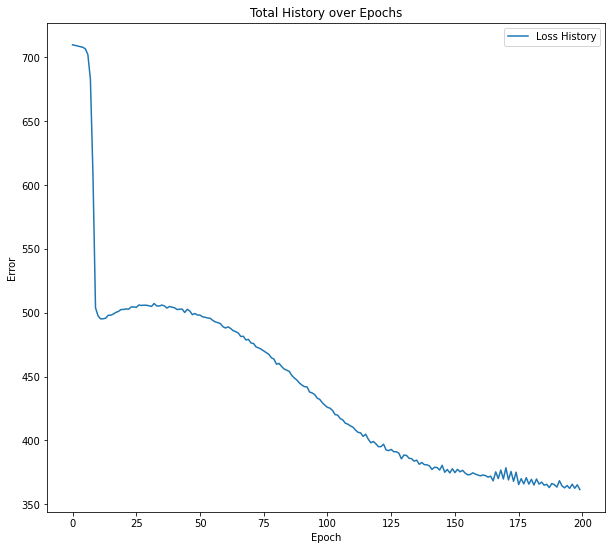

42
[array([[31.62454378]]), array([[32.48119836]]), array([[30.64761931]]), array([[35.41614622]]), array([[31.32658825]]), array([[33.30634779]]), array([[34.21361627]]), array([[31.37717718]]), array([[35.24535472]]), array([[35.93501135]]), array([[33.75747348]]), array([[32.09611059]]), array([[36.80691388]]), array([[31.63524437]]), array([[35.25410785]]), array([[39.83113953]]), array([[28.89303815]]), array([[31.01342207]]), array([[33.33203136]]), array([[29.47365607]]), array([[32.17294097]]), array([[5.48264104]]), array([[6.45623316]]), array([[6.57797761]]), array([[7.13746917]]), array([[7.79128041]]), array([[7.67464531]]), array([[4.76309109]]), array([[8.98184947]]), array([[9.12346831]]), array([[6.28457066]]), array([[5.70045593]]), array([[5.65275436]]), array([[6.98458767]]), array([[6.06890796]]), array([[6.03705401]]), array([[5.82020622]]), array([[7.1599828]]), array([[13.84198989]]), array([[13.8548602]]), array([[13.53486533]]), array([[13.04967469]])]
Data to

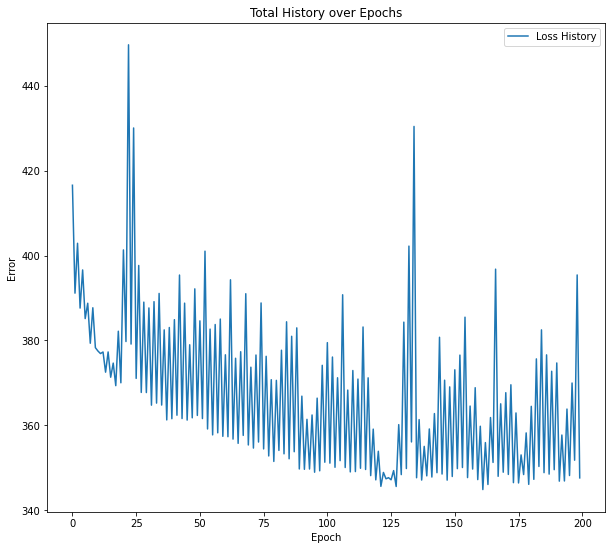

42
[array([[43.86643534]]), array([[46.28943589]]), array([[41.17954722]]), array([[43.42025437]]), array([[40.44789631]]), array([[40.87679597]]), array([[40.87020688]]), array([[43.72895583]]), array([[42.6181206]]), array([[43.14212004]]), array([[41.27619381]]), array([[39.36185137]]), array([[43.26230941]]), array([[43.70552408]]), array([[40.02083711]]), array([[40.487363]]), array([[42.78849875]]), array([[42.45331223]]), array([[44.92015948]]), array([[43.58571877]]), array([[46.71688644]]), array([[8.02349624]]), array([[7.14011067]]), array([[7.31761587]]), array([[9.19631404]]), array([[6.98936813]]), array([[7.41940442]]), array([[4.08267761]]), array([[5.98400502]]), array([[7.4521473]]), array([[7.68877089]]), array([[10.19293934]]), array([[6.8145163]]), array([[7.59580584]]), array([[7.99524272]]), array([[7.75501406]]), array([[8.8685326]]), array([[6.52842497]]), array([[8.14929382]]), array([[8.37337244]]), array([[10.35900753]]), array([[7.06486007]])]
Data to train

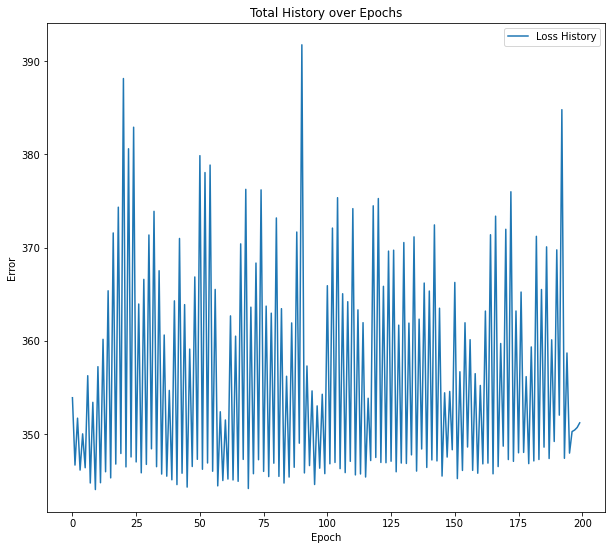

42
[array([[45.14040299]]), array([[46.39540821]]), array([[50.64020722]]), array([[50.30189819]]), array([[48.44917881]]), array([[43.3173171]]), array([[47.79695783]]), array([[44.36528675]]), array([[42.9902707]]), array([[46.55369427]]), array([[46.45361319]]), array([[44.9334724]]), array([[43.61200513]]), array([[44.25843017]]), array([[48.21896627]]), array([[42.29700761]]), array([[45.77430427]]), array([[43.557217]]), array([[42.80995866]]), array([[47.10373144]]), array([[42.06848274]]), array([[7.52057711]]), array([[5.65554178]]), array([[3.57049735]]), array([[5.26174079]]), array([[6.10460806]]), array([[5.79843467]]), array([[6.61236541]]), array([[6.21406764]]), array([[6.36928431]]), array([[7.67008503]]), array([[3.14150151]]), array([[5.77733561]]), array([[6.1931453]]), array([[3.57439605]]), array([[4.69133973]]), array([[7.24428031]]), array([[5.0458879]]), array([[6.27492997]]), array([[5.32906879]]), array([[3.76212431]]), array([[6.05039408]])]
Data to train: [

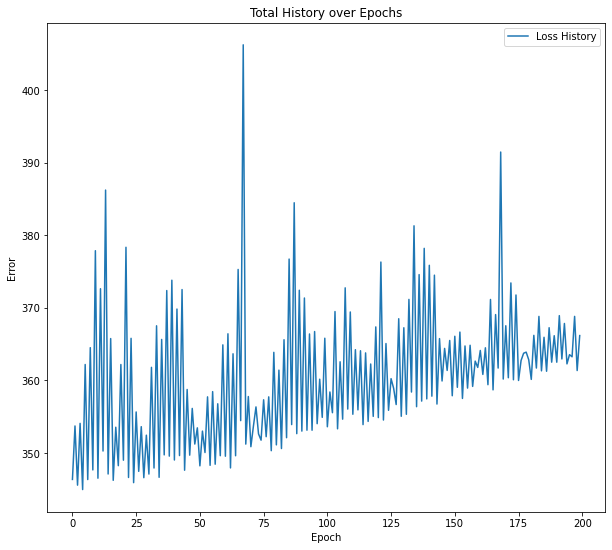

42
[array([[54.88834353]]), array([[49.7502276]]), array([[52.34357565]]), array([[53.98508056]]), array([[52.3058766]]), array([[52.08167869]]), array([[51.02993618]]), array([[48.85034803]]), array([[53.86386007]]), array([[53.41822961]]), array([[54.7814866]]), array([[52.89250007]]), array([[53.19258391]]), array([[55.98855778]]), array([[52.51305936]]), array([[50.49778417]]), array([[51.35629036]]), array([[54.34294586]]), array([[53.30181953]]), array([[54.09514911]]), array([[51.86379789]]), array([[3.85605568]]), array([[5.32449751]]), array([[4.52808191]]), array([[2.53240717]]), array([[3.37755131]]), array([[1.64436518]]), array([[4.68799349]]), array([[3.74468638]]), array([[3.93961395]]), array([[4.44711853]]), array([[6.25165569]]), array([[3.19725314]]), array([[4.11864184]]), array([[3.95258295]]), array([[3.04503301]]), array([[3.96077591]]), array([[6.55037157]]), array([[0.56748123]]), array([[3.43134812]]), array([[3.39791994]]), array([[4.7231603]])]
Data to train

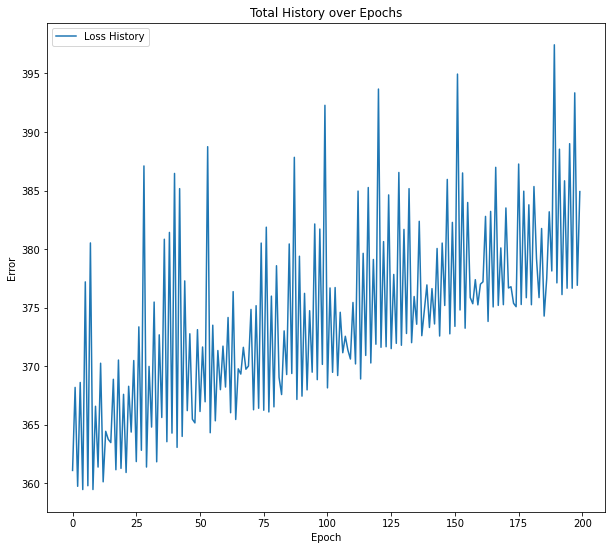

42
[array([[60.2557065]]), array([[61.48620049]]), array([[50.19781373]]), array([[55.61544934]]), array([[57.73758028]]), array([[63.31086155]]), array([[63.09089941]]), array([[61.40790128]]), array([[61.50492614]]), array([[60.06404818]]), array([[63.94479518]]), array([[57.26698753]]), array([[56.83249889]]), array([[60.98500618]]), array([[62.01978128]]), array([[59.91401155]]), array([[60.92875889]]), array([[62.91495496]]), array([[63.37928926]]), array([[63.42458369]]), array([[61.09659203]]), array([[3.23439513]]), array([[3.41185803]]), array([[4.31735802]]), array([[4.88291864]]), array([[3.22190906]]), array([[4.72268365]]), array([[4.73358221]]), array([[4.12333579]]), array([[4.88230309]]), array([[6.70462778]]), array([[4.2927179]]), array([[6.64358588]]), array([[4.03625776]]), array([[4.78165232]]), array([[5.01117109]]), array([[5.18311407]]), array([[5.99562681]]), array([[5.77369695]]), array([[3.11260874]]), array([[4.89413863]]), array([[5.7976628]])]
Data to trai

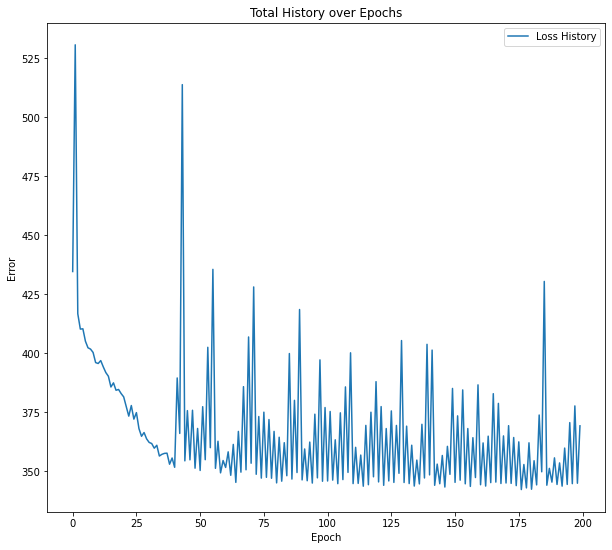

42
[array([[70.30241277]]), array([[68.67424445]]), array([[32.2414579]]), array([[34.47943584]]), array([[44.15725331]]), array([[35.62304197]]), array([[32.93906286]]), array([[30.74280133]]), array([[27.63287041]]), array([[28.02302435]]), array([[34.68713308]]), array([[36.03354235]]), array([[31.87028227]]), array([[43.14183867]]), array([[44.64880335]]), array([[42.05096976]]), array([[40.56927886]]), array([[40.90814974]]), array([[52.76524262]]), array([[47.24113134]]), array([[51.98968134]]), array([[4.72413015]]), array([[2.12272099]]), array([[3.62262865]]), array([[5.08130784]]), array([[4.78867225]]), array([[3.81815957]]), array([[5.54379603]]), array([[3.34377812]]), array([[3.21835749]]), array([[5.01938669]]), array([[4.95818449]]), array([[1.73021518]]), array([[4.40816712]]), array([[3.36788706]]), array([[2.98439821]]), array([[3.07945573]]), array([[4.83876962]]), array([[2.54799116]]), array([[2.60157566]]), array([[4.01220609]]), array([[4.6032657]])]
Data to tra

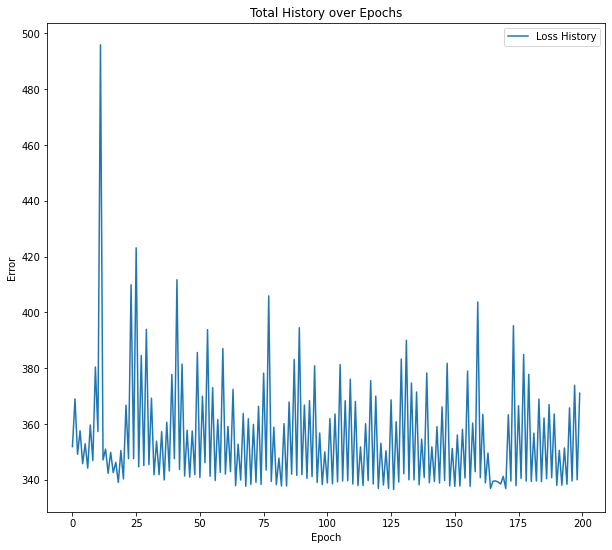

42
[array([[33.46377486]]), array([[35.56848319]]), array([[40.18123214]]), array([[41.10223563]]), array([[39.78335176]]), array([[39.14507398]]), array([[40.18334187]]), array([[40.46995431]]), array([[38.62544898]]), array([[30.83953472]]), array([[48.01571116]]), array([[49.92198725]]), array([[50.93676936]]), array([[25.92424793]]), array([[38.08016404]]), array([[33.98706773]]), array([[39.63036795]]), array([[42.92174181]]), array([[34.23352034]]), array([[31.43386373]]), array([[68.29051071]]), array([[4.56436006]]), array([[4.94661547]]), array([[3.36845818]]), array([[2.12170198]]), array([[4.7184156]]), array([[3.16500925]]), array([[6.11668659]]), array([[3.46430422]]), array([[4.93063406]]), array([[3.65153118]]), array([[5.02426682]]), array([[5.80726964]]), array([[2.94394016]]), array([[3.18729143]]), array([[4.19717894]]), array([[3.68264458]]), array([[6.12506679]]), array([[4.99945623]]), array([[3.13709971]]), array([[2.841011]]), array([[4.28373736]])]
Data to trai

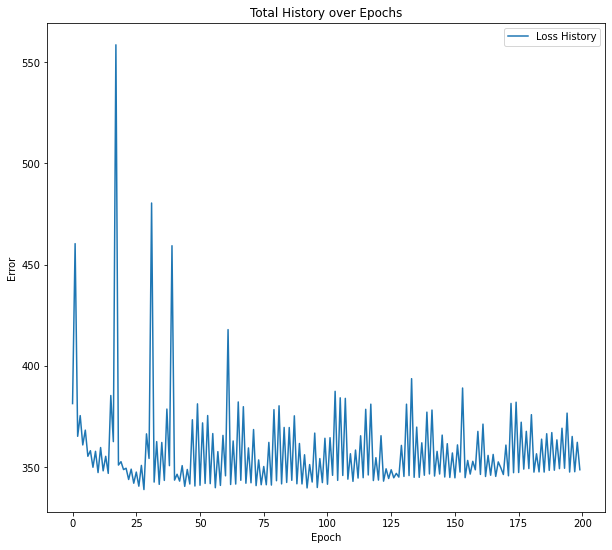

42
[array([[72.24968292]]), array([[50.05665644]]), array([[51.17612496]]), array([[49.88875928]]), array([[51.70817135]]), array([[50.11202526]]), array([[51.05091258]]), array([[49.70792337]]), array([[48.14437863]]), array([[49.90892126]]), array([[48.26238927]]), array([[51.42900401]]), array([[49.49251162]]), array([[49.84934476]]), array([[60.78306082]]), array([[60.44642336]]), array([[60.82018481]]), array([[69.98337324]]), array([[70.06301572]]), array([[41.91695368]]), array([[43.48768505]]), array([[8.43843884]]), array([[8.31973903]]), array([[7.14116715]]), array([[6.36738403]]), array([[7.62902542]]), array([[7.53959068]]), array([[7.01695242]]), array([[6.35870613]]), array([[8.83455481]]), array([[9.82140199]]), array([[7.50050313]]), array([[5.88256413]]), array([[7.20958534]]), array([[7.57771324]]), array([[8.34324963]]), array([[8.41000868]]), array([[8.60130509]]), array([[7.89595373]]), array([[6.98221371]]), array([[8.32992372]]), array([[7.63499266]])]
Data to t

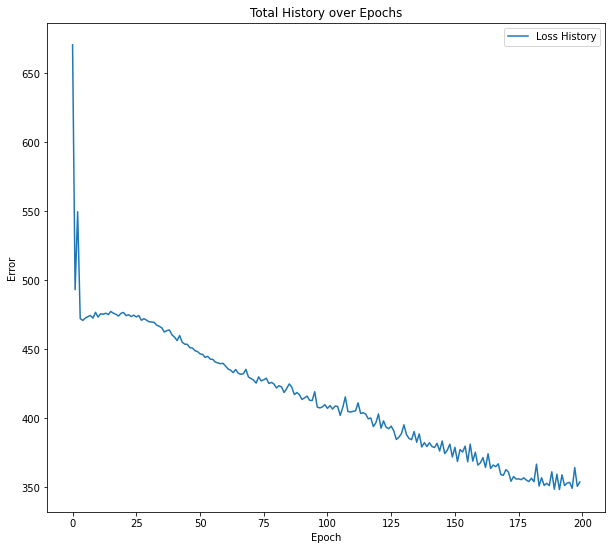

42
[array([[38.65246008]]), array([[37.16854519]]), array([[43.28112135]]), array([[44.37705012]]), array([[47.39438098]]), array([[47.96853605]]), array([[46.24400331]]), array([[44.9793078]]), array([[44.48084949]]), array([[45.80064653]]), array([[52.96898241]]), array([[51.55321111]]), array([[48.19529777]]), array([[50.04193344]]), array([[49.83449201]]), array([[52.68330085]]), array([[53.48103295]]), array([[44.47726105]]), array([[44.5354308]]), array([[46.06126493]]), array([[24.1801094]]), array([[3.37036517]]), array([[4.0002592]]), array([[0.47764393]]), array([[2.928781]]), array([[7.64345203]]), array([[8.70976707]]), array([[6.11061105]]), array([[7.76418084]]), array([[6.56882765]]), array([[1.49595775]]), array([[7.72870811]]), array([[6.76486904]]), array([[6.77105971]]), array([[7.5849824]]), array([[7.21296127]]), array([[0.67472744]]), array([[8.45140365]]), array([[8.58798948]]), array([[7.14464743]]), array([[7.09506732]]), array([[5.56681583]])]
Data to train: [

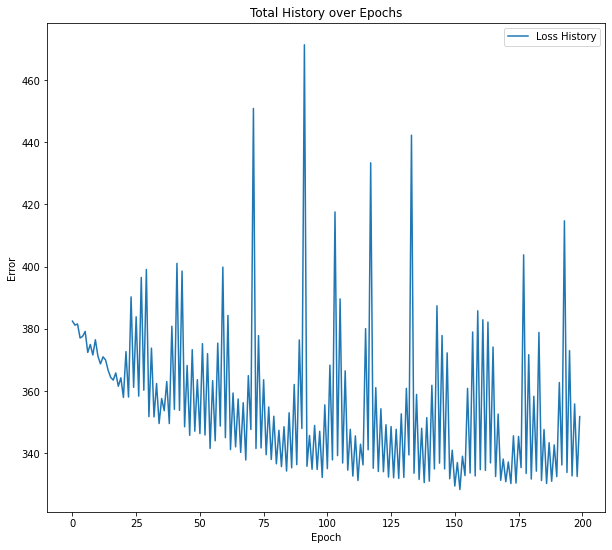

42
[array([[37.73949967]]), array([[36.48007722]]), array([[40.02175404]]), array([[35.46438592]]), array([[39.59599933]]), array([[45.26059068]]), array([[37.76327776]]), array([[44.03302459]]), array([[35.57094509]]), array([[42.89683155]]), array([[38.65119363]]), array([[45.07687967]]), array([[29.48993351]]), array([[23.13868668]]), array([[24.97093225]]), array([[32.50269166]]), array([[32.04188821]]), array([[22.39041206]]), array([[39.54037156]]), array([[33.10315046]]), array([[31.41519857]]), array([[4.70008907]]), array([[4.30506581]]), array([[3.6434028]]), array([[6.7844398]]), array([[6.21593927]]), array([[4.40183898]]), array([[4.02732625]]), array([[5.58989748]]), array([[3.74094305]]), array([[6.66762204]]), array([[4.84653338]]), array([[4.69297959]]), array([[8.88251574]]), array([[5.60517548]]), array([[6.00735825]]), array([[5.05223947]]), array([[4.53298397]]), array([[4.64575394]]), array([[4.14172171]]), array([[3.70960248]]), array([[2.41310289]])]
Data to tra

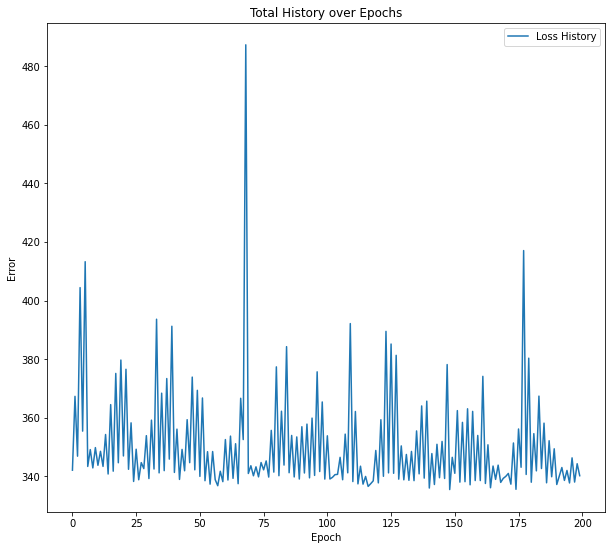

42
[array([[51.52023443]]), array([[46.05392275]]), array([[50.91239166]]), array([[53.55668856]]), array([[51.73283234]]), array([[47.13739959]]), array([[45.18047352]]), array([[49.67603922]]), array([[35.65420796]]), array([[52.17874981]]), array([[54.36245679]]), array([[46.75995783]]), array([[49.83874377]]), array([[52.690326]]), array([[36.35554722]]), array([[59.40460004]]), array([[63.45965375]]), array([[61.82736458]]), array([[45.5531827]]), array([[56.98719932]]), array([[34.79102343]]), array([[10.8701203]]), array([[8.5212274]]), array([[9.96727545]]), array([[7.72157129]]), array([[10.75545806]]), array([[8.62994818]]), array([[9.83306929]]), array([[8.3166105]]), array([[6.95470334]]), array([[8.07061515]]), array([[10.53697372]]), array([[10.3755657]]), array([[7.48402961]]), array([[9.15736574]]), array([[7.42485369]]), array([[9.18619341]]), array([[7.99830072]]), array([[8.5183098]]), array([[8.12997818]]), array([[9.51586612]]), array([[9.34729278]])]
Data to train

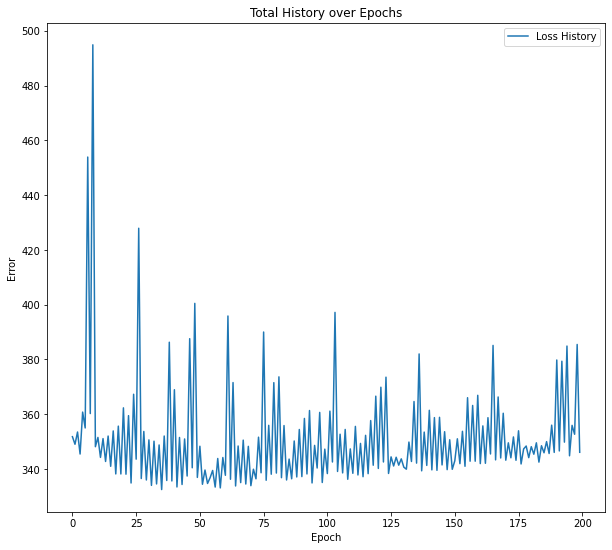

42
[array([[30.99984828]]), array([[51.59586843]]), array([[54.18214937]]), array([[48.58750321]]), array([[51.07332012]]), array([[54.14666541]]), array([[53.25988475]]), array([[51.17055427]]), array([[47.38471656]]), array([[57.91685066]]), array([[59.7473003]]), array([[52.79690196]]), array([[47.88530928]]), array([[49.13485252]]), array([[50.44708946]]), array([[49.30850497]]), array([[50.79878601]]), array([[45.97501414]]), array([[51.23707354]]), array([[56.54156962]]), array([[57.71808988]]), array([[3.64166414]]), array([[7.71756066]]), array([[5.32399575]]), array([[4.42507684]]), array([[8.06987564]]), array([[5.06919421]]), array([[5.41858262]]), array([[2.50066957]]), array([[5.03974858]]), array([[9.3023687]]), array([[8.52228147]]), array([[4.42086485]]), array([[7.36737642]]), array([[4.01919885]]), array([[5.83668387]]), array([[5.7839319]]), array([[5.71647643]]), array([[8.16875184]]), array([[4.79962473]]), array([[7.25538029]]), array([[3.8970422]])]
Data to train

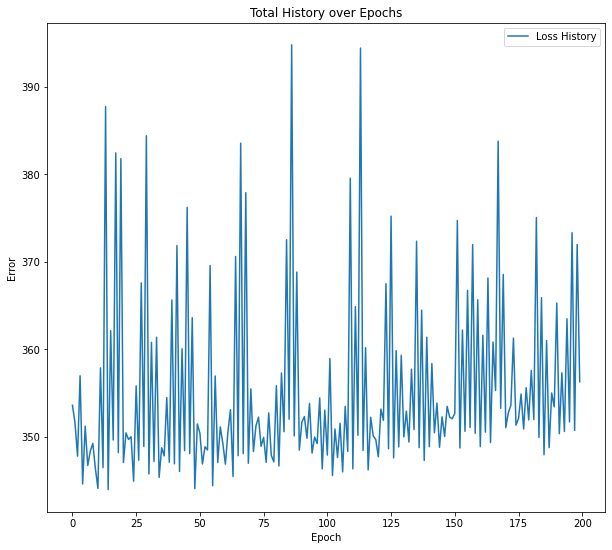

42
[array([[65.37750935]]), array([[52.68099803]]), array([[49.89470425]]), array([[59.67516448]]), array([[64.25784306]]), array([[44.10692868]]), array([[58.36508578]]), array([[63.77740253]]), array([[51.88205981]]), array([[58.50400949]]), array([[48.87074817]]), array([[56.46332396]]), array([[72.71328652]]), array([[66.61015193]]), array([[61.95829852]]), array([[68.71119551]]), array([[66.35245818]]), array([[67.13758752]]), array([[63.76392649]]), array([[69.33091863]]), array([[65.96187634]]), array([[9.11488397]]), array([[15.68997315]]), array([[11.81392567]]), array([[13.12261334]]), array([[10.82154252]]), array([[13.9912663]]), array([[10.50766558]]), array([[11.10089782]]), array([[12.22900405]]), array([[12.217969]]), array([[12.13493721]]), array([[15.28650996]]), array([[11.41619073]]), array([[9.32347446]]), array([[11.53485991]]), array([[13.14559151]]), array([[11.46344421]]), array([[6.68105867]]), array([[11.84229367]]), array([[12.3240491]]), array([[11.5901381]

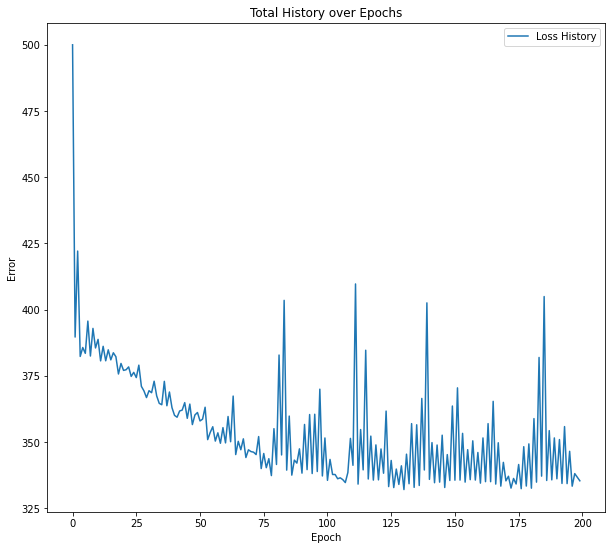

42
[array([[47.55100869]]), array([[54.73921294]]), array([[43.32925139]]), array([[38.66566299]]), array([[41.31624831]]), array([[36.53107947]]), array([[41.55218068]]), array([[41.15392161]]), array([[44.52913196]]), array([[43.82448497]]), array([[36.43286837]]), array([[40.43282884]]), array([[57.83401887]]), array([[58.98999163]]), array([[55.474242]]), array([[48.06307854]]), array([[32.16644899]]), array([[40.63920461]]), array([[58.26474528]]), array([[38.97153335]]), array([[50.35340757]]), array([[4.57671161]]), array([[7.46190532]]), array([[5.65461045]]), array([[7.7634947]]), array([[8.01487204]]), array([[3.44400121]]), array([[6.62283881]]), array([[7.64632278]]), array([[5.86410774]]), array([[7.18346191]]), array([[5.90725974]]), array([[4.58865201]]), array([[8.35811543]]), array([[9.06713652]]), array([[11.02135543]]), array([[6.99755937]]), array([[6.29654274]]), array([[6.30560495]]), array([[6.53604439]]), array([[12.07614889]]), array([[5.90887991]])]
Data to tr

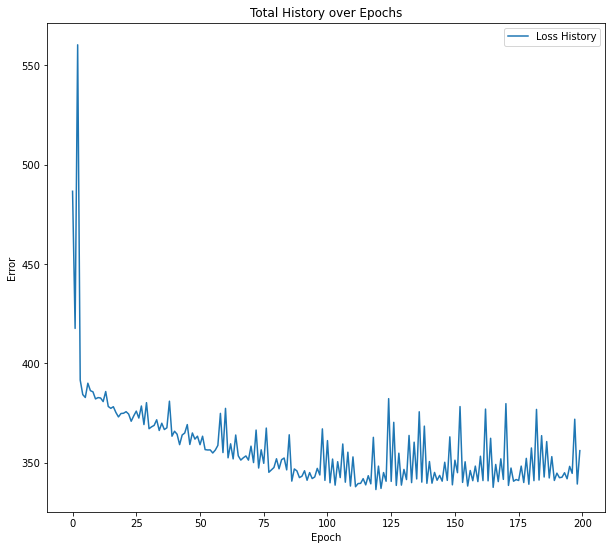

42
[array([[58.16489471]]), array([[52.62829945]]), array([[35.0554423]]), array([[50.01682355]]), array([[36.63408615]]), array([[25.41211179]]), array([[38.37956338]]), array([[50.89475426]]), array([[46.10651792]]), array([[44.85663446]]), array([[57.30466712]]), array([[51.57063707]]), array([[53.57476902]]), array([[41.30132189]]), array([[43.21618877]]), array([[40.94229665]]), array([[44.91219714]]), array([[57.38349884]]), array([[39.01694339]]), array([[56.25344911]]), array([[48.07086118]]), array([[5.41721666]]), array([[6.69244405]]), array([[2.94269574]]), array([[3.69927486]]), array([[5.80297866]]), array([[3.16451042]]), array([[5.16059581]]), array([[6.3514194]]), array([[4.196173]]), array([[6.08890286]]), array([[5.97193788]]), array([[7.88992511]]), array([[3.3826667]]), array([[4.0459391]]), array([[4.19061211]]), array([[2.86423294]]), array([[8.10486319]]), array([[7.72059156]]), array([[6.77330294]]), array([[4.88181706]]), array([[5.1660458]])]
Data to train: [

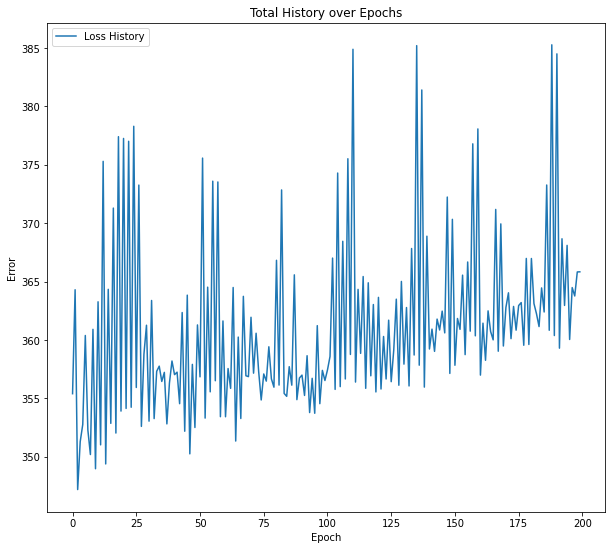

42
[array([[53.24293383]]), array([[49.30229502]]), array([[65.57584919]]), array([[58.38850553]]), array([[44.06110191]]), array([[50.63386083]]), array([[58.45893095]]), array([[47.75749014]]), array([[55.22488458]]), array([[67.34886472]]), array([[50.93461291]]), array([[60.92993016]]), array([[44.76023262]]), array([[67.06254536]]), array([[68.63045266]]), array([[64.64350624]]), array([[57.07263187]]), array([[61.12438843]]), array([[60.54707313]]), array([[57.54659716]]), array([[33.70674882]]), array([[5.84273635]]), array([[2.35877477]]), array([[3.98229963]]), array([[8.03735121]]), array([[6.29741383]]), array([[6.08742854]]), array([[4.44533104]]), array([[6.78026495]]), array([[6.38137589]]), array([[5.63947655]]), array([[7.7292737]]), array([[2.0924439]]), array([[7.10584765]]), array([[4.91704173]]), array([[3.65982341]]), array([[6.51790544]]), array([[3.20178138]]), array([[2.31050081]]), array([[3.55620034]]), array([[5.73528348]]), array([[4.96887727]])]
Data to tra

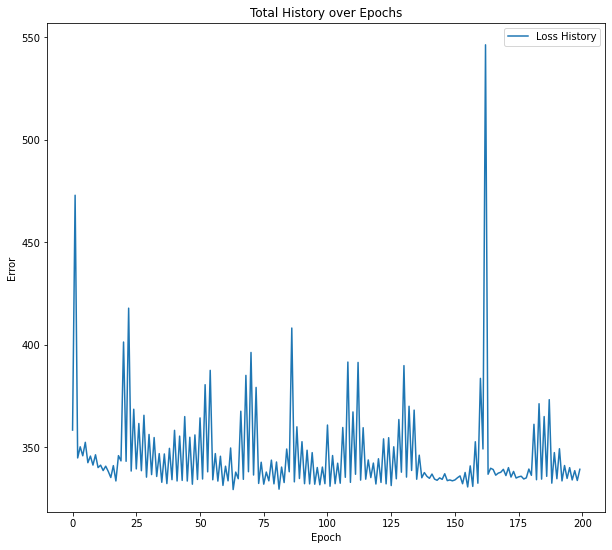

42
[array([[31.46355649]]), array([[49.31739897]]), array([[54.07535345]]), array([[45.88022602]]), array([[59.36153974]]), array([[43.85817745]]), array([[38.35816038]]), array([[70.86632692]]), array([[49.03746173]]), array([[44.12563867]]), array([[37.57214379]]), array([[35.15182809]]), array([[43.46830271]]), array([[42.86307336]]), array([[38.05380849]]), array([[32.80480215]]), array([[38.30097249]]), array([[43.34679419]]), array([[45.28578813]]), array([[42.20555255]]), array([[45.11087278]]), array([[4.52892793]]), array([[5.7781618]]), array([[5.53494647]]), array([[5.04904218]]), array([[4.24970095]]), array([[3.80105714]]), array([[7.69741247]]), array([[3.87397974]]), array([[4.83945689]]), array([[5.5761228]]), array([[3.41294853]]), array([[6.1932562]]), array([[4.90860972]]), array([[5.6944177]]), array([[5.91790415]]), array([[6.53295216]]), array([[6.94595207]]), array([[5.78933513]]), array([[7.16522204]]), array([[4.85160465]]), array([[10.3433613]])]
Data to train

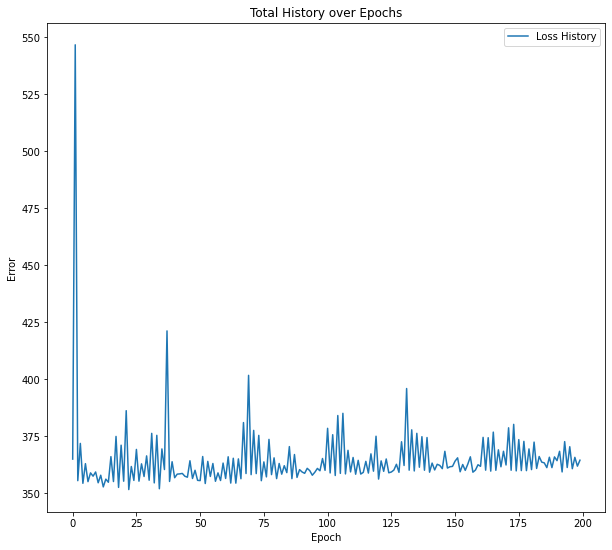

42
[array([[44.19420379]]), array([[50.46267506]]), array([[47.41800536]]), array([[39.58242276]]), array([[39.81769263]]), array([[51.74713112]]), array([[63.02476883]]), array([[58.61669697]]), array([[49.78181278]]), array([[68.48077411]]), array([[61.74952436]]), array([[41.02992531]]), array([[63.91925534]]), array([[73.53600877]]), array([[36.76475051]]), array([[69.15042499]]), array([[36.23159729]]), array([[47.21981148]]), array([[78.0643301]]), array([[63.76084061]]), array([[80.29824505]]), array([[5.04438202]]), array([[11.38137158]]), array([[4.67382597]]), array([[8.43919294]]), array([[3.61175418]]), array([[5.22135121]]), array([[8.49017457]]), array([[6.09667246]]), array([[9.50312805]]), array([[4.94735531]]), array([[7.14607417]]), array([[8.91384602]]), array([[5.65769183]]), array([[6.12865212]]), array([[5.2174222]]), array([[5.99686499]]), array([[7.68865966]]), array([[4.89455887]]), array([[3.8703944]]), array([[4.13364134]]), array([[2.82366818]])]
Data to tra

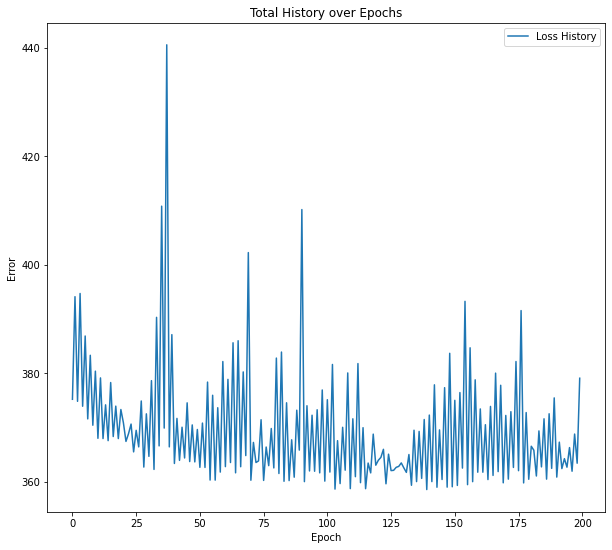

42
[array([[73.20295199]]), array([[65.08475135]]), array([[79.30106986]]), array([[72.99807622]]), array([[70.13556999]]), array([[59.39689352]]), array([[28.93224345]]), array([[55.18476008]]), array([[45.3510206]]), array([[42.08144034]]), array([[35.12483756]]), array([[62.81755485]]), array([[40.1524275]]), array([[62.91977344]]), array([[65.3782082]]), array([[46.8586944]]), array([[37.32495049]]), array([[50.18235012]]), array([[49.25356962]]), array([[46.61408361]]), array([[45.49909688]]), array([[2.93852133]]), array([[3.18054911]]), array([[4.31628375]]), array([[6.2084657]]), array([[4.0024338]]), array([[3.83369122]]), array([[4.2960203]]), array([[3.93144336]]), array([[10.70259049]]), array([[5.95961935]]), array([[3.55864542]]), array([[2.70953966]]), array([[8.76022966]]), array([[4.51449586]]), array([[3.99875586]]), array([[5.09935114]]), array([[4.54669616]]), array([[3.40838826]]), array([[6.27092825]]), array([[6.53193289]]), array([[1.789477]])]
Data to train: [[

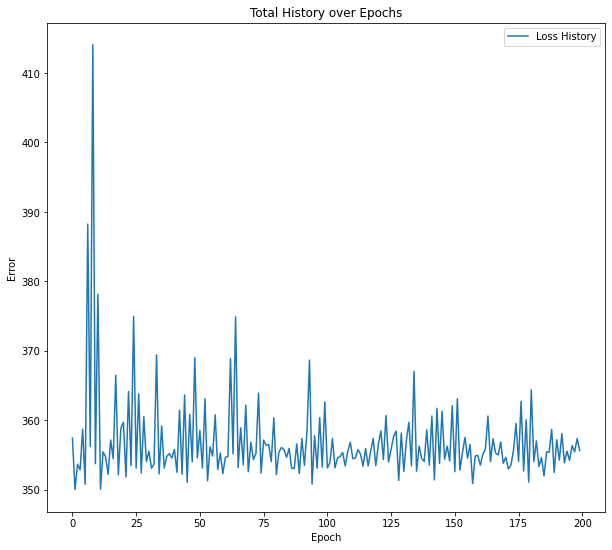

42
[array([[49.73679903]]), array([[45.19896769]]), array([[51.64367392]]), array([[54.5995784]]), array([[57.85261134]]), array([[54.15253425]]), array([[58.72196686]]), array([[45.14947596]]), array([[53.42641383]]), array([[55.3470758]]), array([[47.64481601]]), array([[60.81599382]]), array([[44.92986176]]), array([[57.0530822]]), array([[51.16346702]]), array([[46.24753492]]), array([[55.64391148]]), array([[54.48721589]]), array([[55.35408719]]), array([[62.96677502]]), array([[55.40524324]]), array([[3.32925386]]), array([[4.71885548]]), array([[4.63052901]]), array([[4.7875202]]), array([[3.80493696]]), array([[2.50624679]]), array([[6.61022411]]), array([[7.53164901]]), array([[3.33009614]]), array([[4.1633348]]), array([[2.72307724]]), array([[3.48947065]]), array([[4.6594492]]), array([[6.37209972]]), array([[2.22941933]]), array([[3.02460696]]), array([[3.08484256]]), array([[6.60122233]]), array([[5.25873988]]), array([[7.92727848]]), array([[9.18986363]])]
Data to train: 

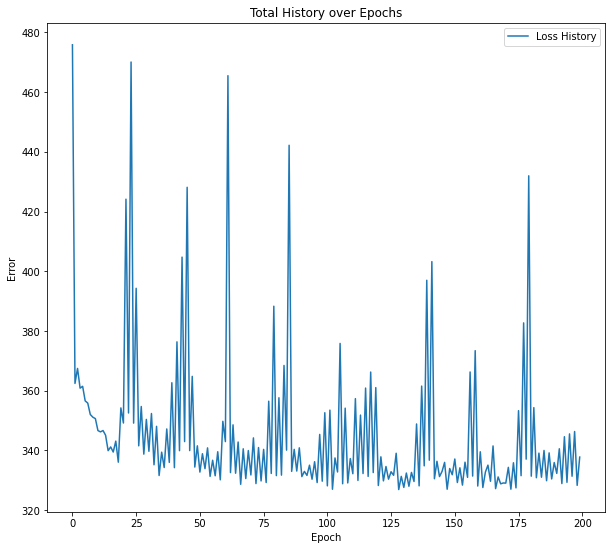

42
[array([[49.00845124]]), array([[45.06881298]]), array([[39.32028946]]), array([[43.80769672]]), array([[40.30448491]]), array([[41.24027629]]), array([[44.62144049]]), array([[39.60223876]]), array([[54.96211818]]), array([[34.9331134]]), array([[43.12507162]]), array([[37.0156068]]), array([[36.65237326]]), array([[44.38694211]]), array([[36.15485106]]), array([[45.4797078]]), array([[33.39442335]]), array([[43.98896658]]), array([[39.84406854]]), array([[44.96631183]]), array([[45.30673472]]), array([[5.98361276]]), array([[9.35887561]]), array([[2.65355425]]), array([[6.02209342]]), array([[9.52343994]]), array([[7.00363714]]), array([[10.14335054]]), array([[2.54646303]]), array([[3.15805674]]), array([[4.27718392]]), array([[5.83397004]]), array([[4.78295835]]), array([[3.16258671]]), array([[6.5572754]]), array([[4.60445056]]), array([[3.68776098]]), array([[2.1386254]]), array([[4.77931808]]), array([[8.94516602]]), array([[4.48552834]]), array([[6.12022841]])]
Data to train

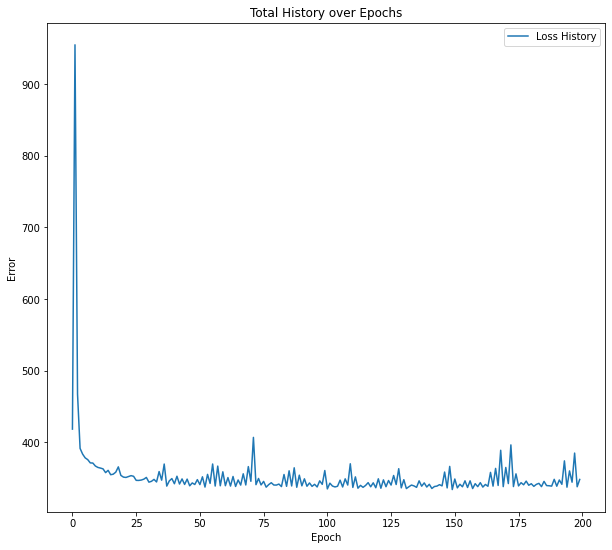

42
[array([[59.08878597]]), array([[42.54585725]]), array([[39.63126772]]), array([[70.1757286]]), array([[50.92955204]]), array([[42.53042999]]), array([[56.22910252]]), array([[38.42933363]]), array([[43.39954573]]), array([[46.05630315]]), array([[44.0333437]]), array([[53.78658788]]), array([[39.58756167]]), array([[48.44327768]]), array([[38.40499571]]), array([[36.91266733]]), array([[42.82065087]]), array([[56.00173883]]), array([[42.69225968]]), array([[50.23061321]]), array([[33.76584268]]), array([[4.27050898]]), array([[4.11315321]]), array([[4.56457884]]), array([[5.76571644]]), array([[7.3596319]]), array([[8.41060815]]), array([[6.9995312]]), array([[1.86755696]]), array([[5.61735882]]), array([[7.29736949]]), array([[8.76123112]]), array([[7.63862077]]), array([[5.61091511]]), array([[7.2088026]]), array([[3.32545299]]), array([[0.68217636]]), array([[4.21457511]]), array([[6.60627748]]), array([[5.35994641]]), array([[2.44723441]]), array([[7.12230305]])]


In [11]:
# Train the VAE
epochs = 200
learning_rate = 0.0001
# print(data_good_wafer.shape)
# print(label_good_wafer.shape)

latent_val_good = []
latent_val_bad = []

for i in range(22):
    good_training_step = 21
    bad_training_step = 21

    bad_wafer_df = training_df[ (training_df['failureType'] != 'none')]
    good_wafer_df = training_df[ (training_df['failureType'] == 'none')]
    bad_wafer_df = bad_wafer_df[bad_wafer_df['waferMap'].apply(lambda x: filter_condition(x, 'bad'))]
    good_wafer_df = good_wafer_df[good_wafer_df['waferMap'].apply(lambda x: filter_condition(x, 'good'))]

    # Label data for bad wafer
    label_bad_wafer = np.tile(base_bad_valid,(bad_training_step,1))

    # Label data for good wafer
    label_good_wafer = np.tile(base_good_valid,(good_training_step,1))

    bad_wafer_df = bad_wafer_df[bad_training_step*i:bad_training_step * (i+1)] 
    good_wafer_df = good_wafer_df[good_training_step*i:good_training_step * (i+1)]

    # Scale all image to asme dimension then flatten it to single row
    data_bad_wafer = np.stack(bad_wafer_df['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
    data_bad_wafer[data_bad_wafer>2] = 2

    data_good_wafer = np.stack(good_wafer_df['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
    data_good_wafer[data_good_wafer>2] = 2

    label_train = np.concatenate((label_bad_wafer, label_good_wafer), axis=0)
    data_train = np.concatenate((data_bad_wafer, data_good_wafer), axis=0)

    label_train = np.where(label_train == 0, 0 , np.where(label_train == 1, 0.5, 1))
    data_train = np.where(data_train == 0, 0 , np.where(data_train == 1, 0.5, 1))
    
    curr_val_latent = vae.train(data_train, label_train, epochs, learning_rate)
    print(len(curr_val_latent))
    print(curr_val_latent)
    latent_val_bad.append(curr_val_latent[:bad_training_step])
    latent_val_good.append(curr_val_latent[bad_training_step:])

### Visualizing Latent Values

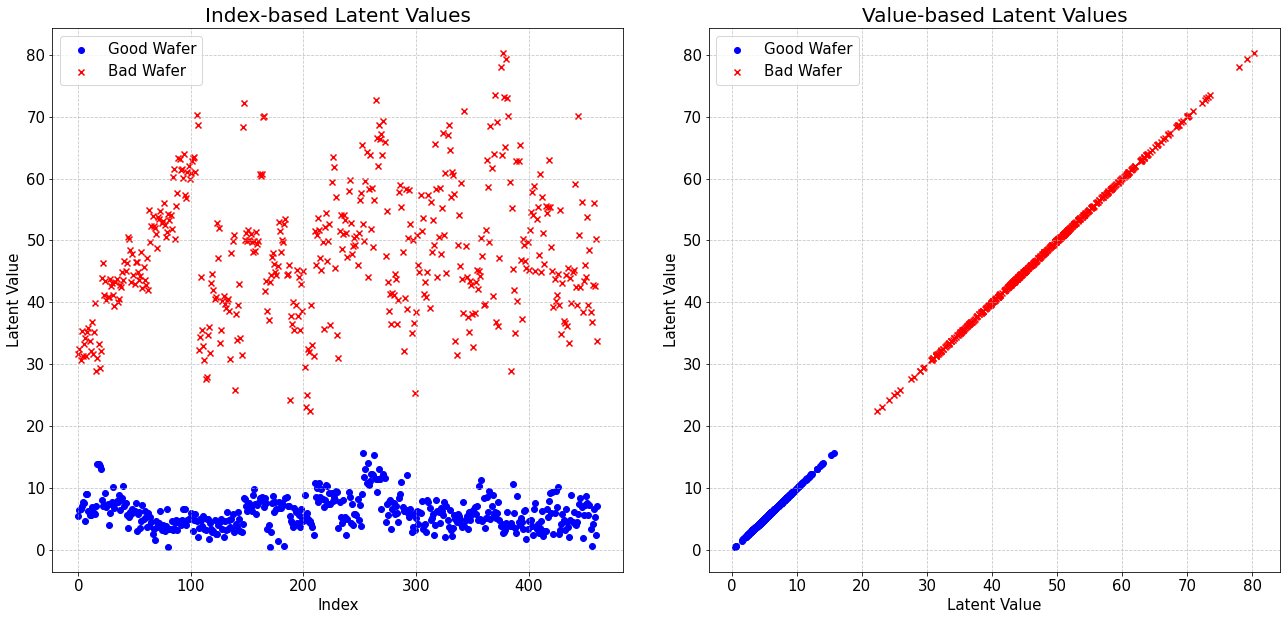

In [12]:
latent_bad_wafer = np.concatenate([np.concatenate(sublist).flatten() for sublist in latent_val_bad])
latent_good_wafer = np.concatenate([np.concatenate(sublist).flatten() for sublist in latent_val_good])

def plot_latent(good_latent,bad_latent, fig_type="xy"):
    if fig_type=='both':
        # Define figure and subplots
        fig, axes = plt.subplots(1, 2, figsize=(22, 10))
        label_fontsize = max(12, min(20, int(fig.get_figheight() * 1.5)))  # Adjust dynamically
        title_fontsize = label_fontsize + 5
        scale_fontsize = label_fontsize
        
        # Subplot 1: Index-based scatter plot
        axes[0].scatter(range(len(good_latent)), good_latent, marker='o', color='blue', label='Good Wafer')
        axes[0].scatter(range(len(bad_latent)), bad_latent, marker='x', color='red', label='Bad Wafer')
        axes[0].set_xlabel("Index", fontsize=label_fontsize)
        axes[0].set_ylabel("Latent Value", fontsize=label_fontsize)
        axes[0].set_title("Index-based Latent Values", fontsize=title_fontsize)
        axes[0].legend(fontsize=label_fontsize)
        axes[0].grid(True, linestyle='--', alpha=0.7)
        axes[0].tick_params(axis='both', labelsize=scale_fontsize)  # Scale font

        # Subplot 2: Value-based scatter plot
        axes[1].scatter(good_latent, good_latent, marker='o', color='blue', label='Good Wafer')
        axes[1].scatter(bad_latent, bad_latent, marker='x', color='red', label='Bad Wafer')
        axes[1].set_xlabel("Latent Value", fontsize=label_fontsize)
        axes[1].set_ylabel("Latent Value", fontsize=label_fontsize)
        axes[1].set_title("Value-based Latent Values", fontsize=title_fontsize)
        axes[1].legend(fontsize=label_fontsize)
        axes[1].grid(True, linestyle='--', alpha=0.7)
        axes[1].tick_params(axis='both', labelsize=scale_fontsize)

        # Adjust layout and show the plot
        plt.subplots_adjust(wspace=0.15)
        # plt.tight_layout()
        plt.show()
    

    elif fig_type == "index":
        plt.figure(figsize=(15, 13))
        label_fontsize = 20; title_fontsize=25

        # Plot good wafers with 'o'
        plt.scatter(range(len(good_latent)), good_latent, marker='o', color='blue', label='Good Wafer')
        # Plot bad wafers with 'x'
        plt.scatter(range(len(bad_latent)), bad_latent, marker='x', color='red', label='Bad Wafer')

        # Adding labels, legend, and title
        plt.xlabel("Index", fontsize=label_fontsize)
        plt.ylabel("Latent Value", fontsize=label_fontsize)

        plt.title("Latent Values for Good and Bad Wafers", fontsize=title_fontsize)
        plt.legend(fontsize=label_fontsize)
        plt.grid(True, linestyle='--', alpha=0.7)
    
        # Display the plot
        plt.tight_layout()
        plt.show()

    else:
        plt.figure(figsize=(15, 13))
        label_fontsize = 20; title_fontsize=25

        # Plot good wafers with 'o'
        plt.scatter(good_latent, good_latent, marker='o', color='blue', label='Good Wafer')
        # Plot bad wafers with 'x'
        plt.scatter(bad_latent, bad_latent, marker='x', color='red', label='Bad Wafer')
        # Adding labels, legend, and title
        plt.xlabel("Latent Value", fontsize=label_fontsize)
        plt.ylabel("Latent Value", fontsize=label_fontsize)

        plt.title("Latent Values for Good and Bad Wafers", fontsize=title_fontsize)
        plt.legend(fontsize=label_fontsize)
        plt.grid(True, linestyle='--', alpha=0.7)

        # Display the plot
        plt.tight_layout()
        plt.show()

    

plot_latent(latent_good_wafer,latent_bad_wafer,'both')

#### Get Params

In [13]:
param_W_enc, param_B_enc, param_W_mu, param_B_mu, param_W_var, param_B_var, param_W_dec, param_B_dec, param_W_out, param_B_out = vae.get_train_param()

(2048, 1)


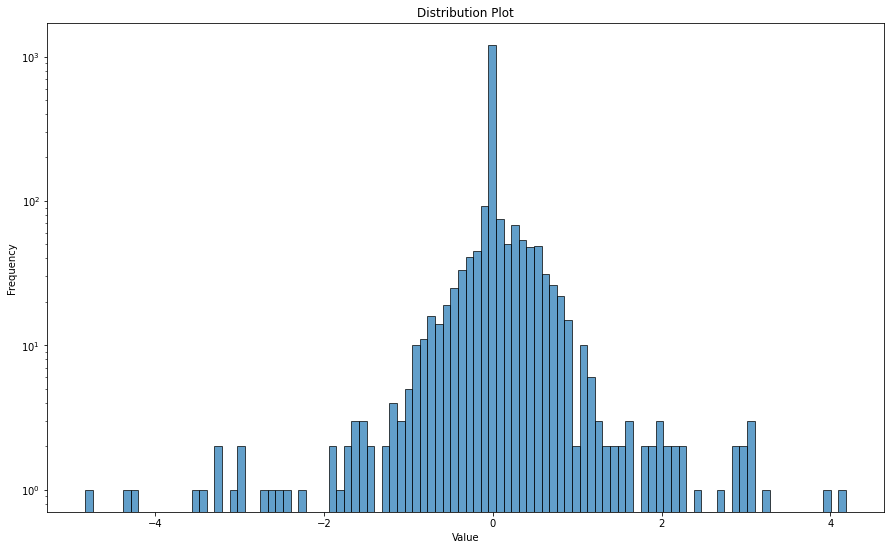

In [14]:
all_weight = np.concatenate((param_W_mu,param_W_var))
print(all_weight.shape)
# Create the distribution plot
plt.figure(figsize=(15,9))
plt.hist(all_weight, bins=100, edgecolor='black', alpha=0.7,log=True)  # Adjust the number of bins as needed

# Label axes
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution Plot')
# Show the plot
plt.show()

### Export Weight, Bias, and Input to txt

#### Float to Fixed Point and Vice versa Converters

In [15]:
def float_to_fp(value, total_bits=16, frac_bits=8, output_format='hex'):
    # Step 1: Check if the value is negative
    if value < 0:
        is_negative = True
        value = -value  # Work with the positive equivalent for conversion
    else:
        is_negative = False

    # Step 2: Multiply the float by 2^frac_bits to scale it
    scaled_value = round(value * (2 ** frac_bits))
    
    # Step 3: Convert the scaled value to a binary string
    # Format the binary string to the required total bits length
    binary_value = bin(scaled_value)[2:].zfill(total_bits)
    # print(f'Scaled Value: {scaled_value}')
    # print(f'Binary Value: {binary_value}')

    # Step 4: Handle the negative case
    if is_negative:
        # Perform two's complement conversion for negative numbers
        # Subtract the binary value from the max value for two's complement
        max_value = (1 << total_bits)  # This is 2^total_bits
        binary_value = bin(max_value - scaled_value)[2:].zfill(total_bits)
        neg_bit_length = len(binary_value)
        if neg_bit_length > total_bits: binary_value = binary_value[neg_bit_length-total_bits:]

    # Step 5: Convert the binary value to hexadecimal
    hex_value = hex(int(binary_value, 2))[2:].zfill(total_bits // 4)  # Convert to hex and remove '0x'

    # Step 6: Format output based on the `output_format` argument
    if output_format == 'binary':
        return binary_value
    elif output_format == 'hex':
        return hex_value
    elif output_format == 'both':
        return (f"{total_bits}'b{binary_value}", f"{total_bits}'h{hex_value}")
    else:
        raise ValueError("Invalid output format. Choose 'binary', 'hex', or 'both'.")
    
def fp_to_float(value,total_bits=16, frac_bits=8, input_format='hex'):
    if input_format == 'binary': fp_val = int(value,2)
    elif input_format == 'hex': fp_val = int(value,16)
    else: raise ValueError("Invalid input format. Must be 'binary' or 'hex'")
    # Calculate the scaling factor: 2^frac_width
    scaling_factor = 2 ** frac_bits
    # Handle two's complement if the sign bit is set (for negative numbers)
    sign_bit_mask = 1 << (total_bits - 1)  # Mask to isolate the sign bit
    
    # Check if the value is negative by examining the sign bit
    if fp_val & sign_bit_mask:  # If sign bit is 1, it's negative
        # Convert from two's complement
        fp_val = fp_val - (1 << total_bits)  # Apply the two's complement adjustment
    
    # Convert to float by dividing by the scaling factor
    float_value = fp_val / scaling_factor
    
    return float_value

# Example usage:
value = 64  # Example float number

num1 = float_to_fp(value)
inv_num1 = fp_to_float(str(num1))
print(num1,inv_num1)

4000 64.0


#### Exporting Weight and Bias to txt

In [16]:
def wr_to_file(np_arr,filename):
    with open(filename, 'w') as f:
        for val in np_arr:
            data = float_to_fp(val[0])
            f.write(data + '\n')

wr_to_file(param_W_mu,"data_tb\\weight_mu.txt")
wr_to_file(param_W_var,"data_tb\\weight_var.txt")
wr_to_file(param_B_mu, "data_tb\\bias_mu.txt")
wr_to_file(param_B_var, "data_tb\\bias_var.txt")

# Edit txt to teffandi's format
# Define function to reorder lines in intervals of 128
def reorder_lines(input_file, output_file):
    # Read all lines from input file
    with open(input_file, 'r') as file:
        lines = file.readlines()
    
    # Check if the file has exactly 1024 lines
    if len(lines) != 1024:
        print(f"Error: The file should contain exactly 1024 lines, but it contains {len(lines)} lines.")
        return
    
    # Initialize list to hold reordered lines
    reordered_lines = [""] * 1024
    
    # Reorder lines in intervals of 128
    temp = 0
    for i in range(0,128):
        for j in range (0,8):
            interval_lines = lines[i+j*127]
            reordered_lines[temp] = str(interval_lines)
            temp = temp + 1
    
    # Write reordered lines to output file
    with open(output_file, 'w') as file:
        file.writelines(reordered_lines)

# Use the function to reorder lines from 'input.txt' to 'output.txt'
reorder_lines("data_tb\\weight_mu.txt", "data_tb\\mu.txt")
reorder_lines("data_tb\\weight_var.txt", "data_tb\\var.txt")

#### Exporting Input to txt

In [17]:
print(len(data_train))
print(data_train[1][1])
for i in range(3):
    print(i)

42
0.0
0
1
2


In [18]:
# export as 2 bit

data_train[0]

print(float_to_fp(0,total_bits=2,frac_bits=1,output_format='binary'))


def image_data_txt(np_arr, fn1, fn2, fn3, fn4):
    f1 = open(fn1,'w'); f2 = open(fn2, 'w')
    f3 = open(fn3,'w'); f4 = open(fn4, 'w')

    for idx in range(len(data_train[0])//(32*4)):
        data1 = []; data2 = []; data3 = []; data4 = [];
        idx1 = idx * 128
        idx2 = 32+ idx1
        idx3 = 32+ idx2
        idx4 = 32+ idx3
        fin_idx = 32 + idx4
        
        for i in range(idx2-1,idx1-1,-1): data1.append(float_to_fp(np_arr[i],total_bits=2,frac_bits=1, output_format='binary'))
        for i in range(idx3-1,idx2-1,-1): data2.append(float_to_fp(np_arr[i],total_bits=2,frac_bits=1, output_format='binary'))
        for i in range(idx4-1,idx3-1,-1): data3.append(float_to_fp(np_arr[i],total_bits=2,frac_bits=1, output_format='binary'))
        for i in range(fin_idx-1,idx4-1,-1): data4.append(float_to_fp(np_arr[i],total_bits=2,frac_bits=1, output_format='binary'))

        f1.write(''.join(data1) + '\n')
        f2.write(''.join(data2) + '\n')
        f3.write(''.join(data3) + '\n')
        f4.write(''.join(data4) + '\n')

    f1.close(); f2.close(); f3.close(); f4.close()

fn1 = "..\\rtl_dev_teffandi\\input_bad1.txt"
fn2 = "..\\rtl_dev_teffandi\\input_bad2.txt"
fn3 = "..\\rtl_dev_teffandi\\input_bad3.txt"
fn4 = "..\\rtl_dev_teffandi\\input_bad4.txt"

np_arr = data_train[0]
image_data_txt(np_arr, fn1, fn2, fn3, fn4)

# Full data
def all_image_data_txt(np_arr, fn1, fn2, fn3, fn4):
    f1 = open(fn1,'w'); f2 = open(fn2, 'w')
    f3 = open(fn3,'w'); f4 = open(fn4, 'w')

    for j in range (len(np_arr)):
        for idx in range(len(data_train[j])//(32*4)):
            data1 = []; data2 = []; data3 = []; data4 = [];
            idx1 = idx * 128
            idx2 = 32+ idx1
            idx3 = 32+ idx2
            idx4 = 32+ idx3
            fin_idx = 32 + idx4

            for i in range(idx2-1,idx1-1,-1): data1.append(float_to_fp(np_arr[j][i],total_bits=2,frac_bits=1, output_format='binary'))
            for i in range(idx3-1,idx2-1,-1): data2.append(float_to_fp(np_arr[j][i],total_bits=2,frac_bits=1, output_format='binary'))
            for i in range(idx4-1,idx3-1,-1): data3.append(float_to_fp(np_arr[j][i],total_bits=2,frac_bits=1, output_format='binary'))
            for i in range(fin_idx-1,idx4-1,-1): data4.append(float_to_fp(np_arr[j][i],total_bits=2,frac_bits=1, output_format='binary'))

            f1.write(''.join(data1) + '\n')
            f2.write(''.join(data2) + '\n')
            f3.write(''.join(data3) + '\n')
            f4.write(''.join(data4) + '\n')

    f1.close(); f2.close(); f3.close(); f4.close()
    
fnn1 = "..\\rtl_dev_teffandi\\input1.txt"
fnn2 = "..\\rtl_dev_teffandi\\input2.txt"
fnn3 = "..\\rtl_dev_teffandi\\input3.txt"
fnn4 = "..\\rtl_dev_teffandi\\input4.txt"


all_image_data_txt(data_train, fnn1, fnn2, fnn3, fnn4)

00


### Confusion Matrix

Threshold Range: 0.9620881978122826 to 11.103608295932613

Confusion Matrix:
                                         Actual Good Wafer    Actual Bad Wafer    
Predicted Good Wafer                     437                  0                   
Predicted Bad Wafer                      25                   462                 


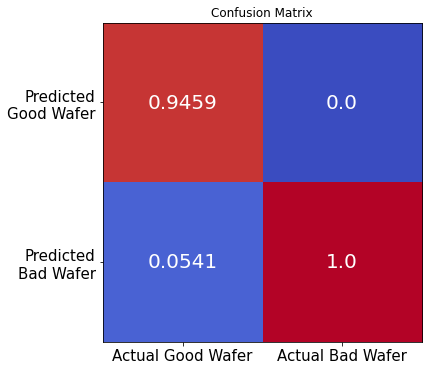

In [19]:
# latent_good_wafer = latent_val[train_max_row:]
# latent_bad_wafer = latent_val[:train_max_row]
# Compute mean and std for good wafer latent values
good_mean = np.mean(latent_good_wafer)
good_std = np.std(latent_good_wafer)

# Define thresholds
threshold_lower = good_mean - 2 * good_std
threshold_upper = good_mean + 2 * good_std

print(f"Threshold Range: {threshold_lower} to {threshold_upper}")

# Classify each latent value
def classify(np_arr, low_threshold, up_threshold):
    good_elems = np.sum((np_arr >= low_threshold) & (np_arr <= up_threshold))
    return good_elems, len(np_arr)-good_elems

bad_wafer_good_detection, bad_wafer_bad_detection = classify(latent_bad_wafer, threshold_lower, threshold_upper)
good_wafer_good_detection, good_wafer_bad_detection = classify(latent_good_wafer, threshold_lower, threshold_upper)

total_bad_testing_data = len(latent_bad_wafer)
total_good_testing_data = len(latent_good_wafer)

table = np.array([
    ["",    "Actual Good Wafer", "Actual Bad Wafer"],
    ["Predicted Good Wafer", good_wafer_good_detection, bad_wafer_good_detection],
    ["Predicted Bad Wafer", good_wafer_bad_detection, bad_wafer_bad_detection]
])

# Display the table
print("\nConfusion Matrix:")
print("{:<40} {:<20} {:<20}".format(*table[0]))  # Header row
for row in table[1:]:
    print("{:<40} {:<20} {:<20}".format(*row))  # Data rows

confusion_matrix = np.array([
    [np.round(good_wafer_good_detection/total_good_testing_data,4), np.round(bad_wafer_good_detection/total_bad_testing_data,4)],  # Predicted Good: Actual Good, Actual Bad
    [np.round(good_wafer_bad_detection/total_good_testing_data,4), np.round(bad_wafer_bad_detection/total_bad_testing_data,4)]   # Predicted Bad: Actual Good, Actual Bad
])

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(confusion_matrix, cmap="coolwarm")

# Adding labels
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(["Actual Good Wafer", "Actual Bad Wafer"], fontsize=15)
ax.set_yticklabels(["Predicted\nGood Wafer", "Predicted\nBad Wafer"], fontsize=15)

# Rotating tick labels for better readability
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Adding text annotations with text wrapping
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(confusion_matrix[i, j]), ha="center", va="center", color="white", fontsize=20)

# Title and display
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

## Testing to More Data

### Extract Data Testing

In [20]:
max_shape = (40,40)
target_shape = (32,32)
strClass_trainTestLaebl_df = df[df['trainTestLabel'].apply(lambda x: isinstance(x, str))]
limited_df = sizeLimit_df(strClass_trainTestLaebl_df,max_shape,True)
testing_df = limited_df[(limited_df['trainTestLabel'] == 'Training') | (limited_df['trainTestLabel'] == 'Test')]
# testing_df = limited_df[(limited_df['trainTestLabel'] == 'Training') ]

actual_bad_wafer_df = testing_df[(testing_df['failureType'] != 'none')]
actual_good_wafer_df = testing_df[(testing_df['failureType'] == 'none')]

# Function to filter very bad data
def filter_condition(np_arr, wafer_type):
    count_0 = np.sum(np_arr == 0)  # Count occurrences of 1
    count_1 = np.sum(np_arr == 1)  # Count occurrences of 1
    count_2 = np.sum(np_arr == 2)  # Count occurrences of 2
    if wafer_type == 'bad': return (count_2 > 1.5 * count_1) & (count_0 < count_1)  # Check if count of 2 is less than 20% of count of 1
    else: return (count_2 < 0.05 * count_1) & (count_0 < count_1)  # Check if count of 2 is less than 20% of count of 1

actual_bad_wafer_df = actual_bad_wafer_df[actual_bad_wafer_df['waferMap'].apply(lambda x: filter_condition(x, 'bad'))]
actual_good_wafer_df = actual_good_wafer_df[actual_good_wafer_df['waferMap'].apply(lambda x: filter_condition(x, 'good'))]

# Get numpy array of actual data
actual_bad_wafer_data = np.stack(actual_bad_wafer_df['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
actual_good_wafer_data = np.stack(actual_good_wafer_df['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())

actual_bad_wafer_data = actual_bad_wafer_data[:]
actual_good_wafer_data = actual_good_wafer_data[:]

# Prevent data more than 2
actual_bad_wafer_data[actual_bad_wafer_data>2] = 2
actual_good_wafer_data[actual_good_wafer_data>2] = 2

# Rescale data to 0 to 1
actual_bad_wafer_data = np.where(actual_bad_wafer_data == 0, 0 , np.where(actual_bad_wafer_data == 1, 0.5, 1))
actual_good_wafer_data = np.where(actual_good_wafer_data == 0, 0 , np.where(actual_good_wafer_data == 1, 0.5, 1))

print(actual_bad_wafer_data.shape)
print(actual_good_wafer_data.shape)

(103, 1024)
(3401, 1024)


### Input Data to Model and Visualize Scatter

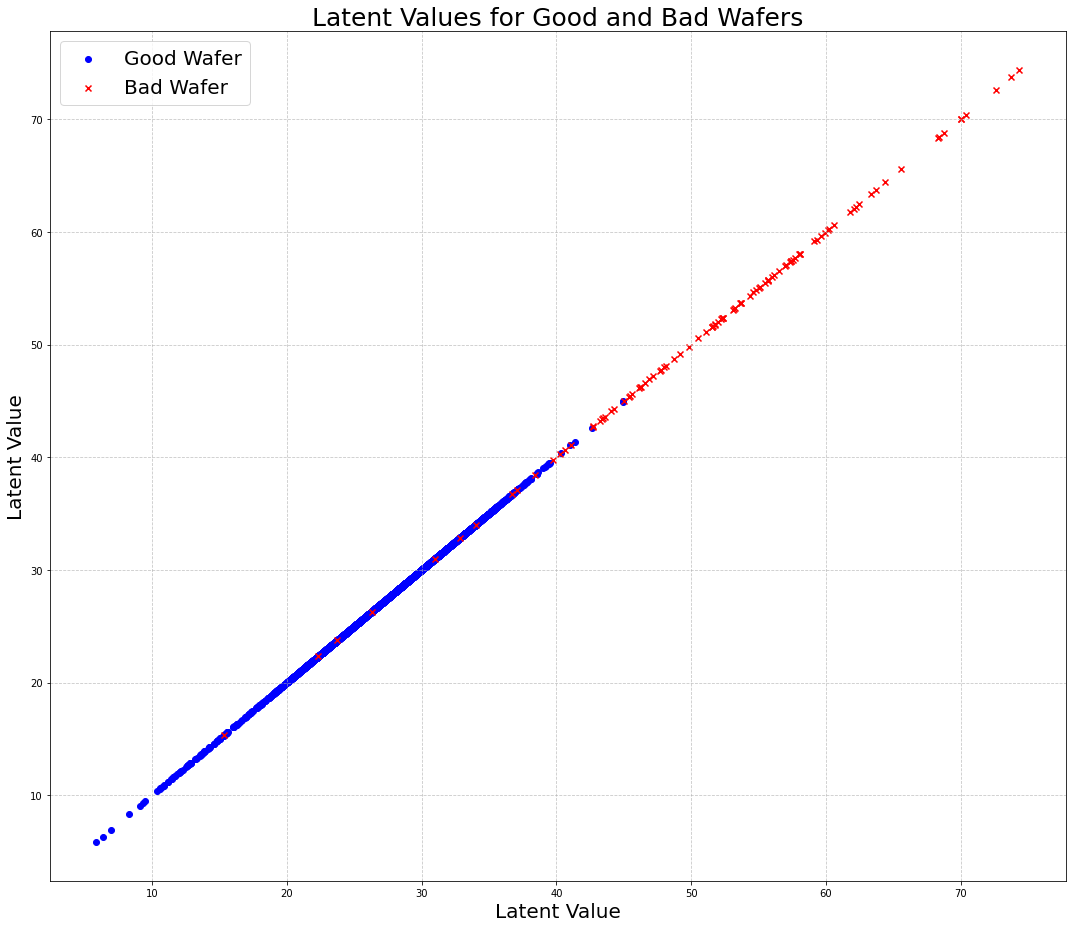

In [21]:
# Testing bad wafer data
def test_data(data_to_test):
    tested_latent_val = []
    for x in data_to_test:
        x = x.reshape(1, -1)
        _, _, _, curr_latent_val, _, _ = vae.forward(x)
        tested_latent_val.append(curr_latent_val)
    return tested_latent_val

latent_predicted_bad_wafer_data = test_data(actual_bad_wafer_data)
latent_predicted_good_wafer_data = test_data(actual_good_wafer_data)

# Compute mean and std for good wafer latent values
good_mean = np.mean(latent_predicted_good_wafer_data)
good_std = np.std(latent_predicted_good_wafer_data)

# Define thresholds
threshold_lower = good_mean - 2 * good_std
threshold_upper = good_mean + 2 * good_std

# Plot latent values
plot_latent(latent_predicted_good_wafer_data, latent_predicted_bad_wafer_data)

### Confusion Matrix of More Data Testing

Threshold Range: 16.968812668639053 to 37.37864348174397

Confusion Matrix:
                                         Actual Good Wafer    Actual Bad Wafer    
Predicted Good Wafer                     3266                 8                   
Predicted Bad Wafer                      135                  95                  


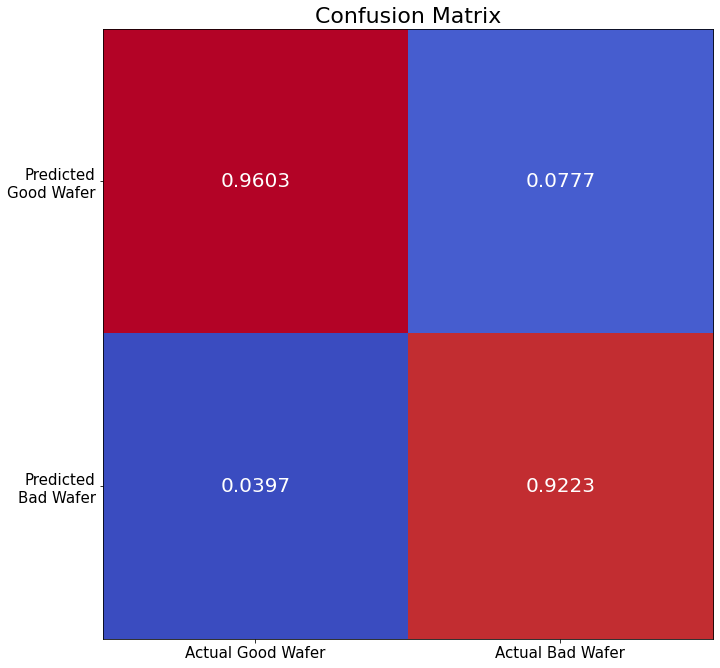

In [22]:
print(f"Threshold Range: {threshold_lower} to {threshold_upper}")

# Classify each latent value
def classify(np_arr, low_threshold, up_threshold):
    good_elems = np.sum((np_arr >= low_threshold) & (np_arr <= up_threshold))
    return good_elems, len(np_arr)-good_elems

good_wafer_good_detection, good_wafer_bad_detection = classify(latent_predicted_good_wafer_data, threshold_lower, threshold_upper)
bad_wafer_good_detection, bad_wafer_bad_detection = classify(latent_predicted_bad_wafer_data, threshold_lower, threshold_upper)

total_bad_testing_data = len(latent_predicted_bad_wafer_data)
total_good_testing_data = len(latent_predicted_good_wafer_data)

table = np.array([
    ["",    "Actual Good Wafer", "Actual Bad Wafer"],
    ["Predicted Good Wafer", good_wafer_good_detection, bad_wafer_good_detection],
    ["Predicted Bad Wafer", good_wafer_bad_detection, bad_wafer_bad_detection]
])

# Display the table
print("\nConfusion Matrix:")
print("{:<40} {:<20} {:<20}".format(*table[0]))  # Header row
for row in table[1:]:
    print("{:<40} {:<20} {:<20}".format(*row))  # Data rows

confusion_matrix = np.array([
    [np.round(good_wafer_good_detection/total_good_testing_data,4), np.round(bad_wafer_good_detection/total_bad_testing_data,4)],  # Predicted Good: Actual Good, Actual Bad
    [np.round(good_wafer_bad_detection/total_good_testing_data,4), np.round(bad_wafer_bad_detection/total_bad_testing_data,4)]   # Predicted Bad: Actual Good, Actual Bad
])

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(confusion_matrix, cmap="coolwarm")

# Adding labels
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(["Actual Good Wafer", "Actual Bad Wafer"], fontsize=15)
ax.set_yticklabels(["Predicted\nGood Wafer", "Predicted\nBad Wafer"], fontsize=15)

# Rotating tick labels for better readability
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Adding text annotations with text wrapping
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(confusion_matrix[i, j]), ha="center", va="center", color="white", fontsize=20)

# Title and display
ax.set_title("Confusion Matrix", fontsize=22)
plt.tight_layout()
plt.show()

In [23]:
result_tb = []
with open("data_tb\\result.txt", 'r') as file:
    for line in file:
        result_tb.append(fp_to_float(line.strip(),total_bits=16, frac_bits=8, input_format='hex'))
resulttb = np.array(result_tb)
print(resulttb)
# Compute mean and std for good wafer latent values
good_mean = np.mean(resulttb[21:42])
good_std = np.std(resulttb[21:42])

# Define thresholds
threshold_lower = good_mean - 2 * good_std
threshold_upper = good_mean + 2 * good_std
good, bad = classify(resulttb, threshold_lower, threshold_upper)
print("Good: " + str(good))
print("Bad: " + str(bad))

[24.69140625 20.484375   21.7421875  23.90625    17.01953125 21.0703125
 30.94140625 24.72265625 28.40625    27.25       22.0234375  24.66796875
 22.98828125 19.703125   18.8515625  22.83203125 24.86328125 20.00390625
 18.03515625 24.55078125 15.48046875 13.16015625 13.0390625  13.921875
 12.35546875 11.57421875 13.0703125  14.703125   14.66796875 12.84375
 12.8359375  14.09375    13.3984375  14.7578125  13.8359375  12.6171875
 14.3828125  14.39453125 13.3671875  14.62109375 15.0859375  14.1171875 ]
Good: 21
Bad: 21


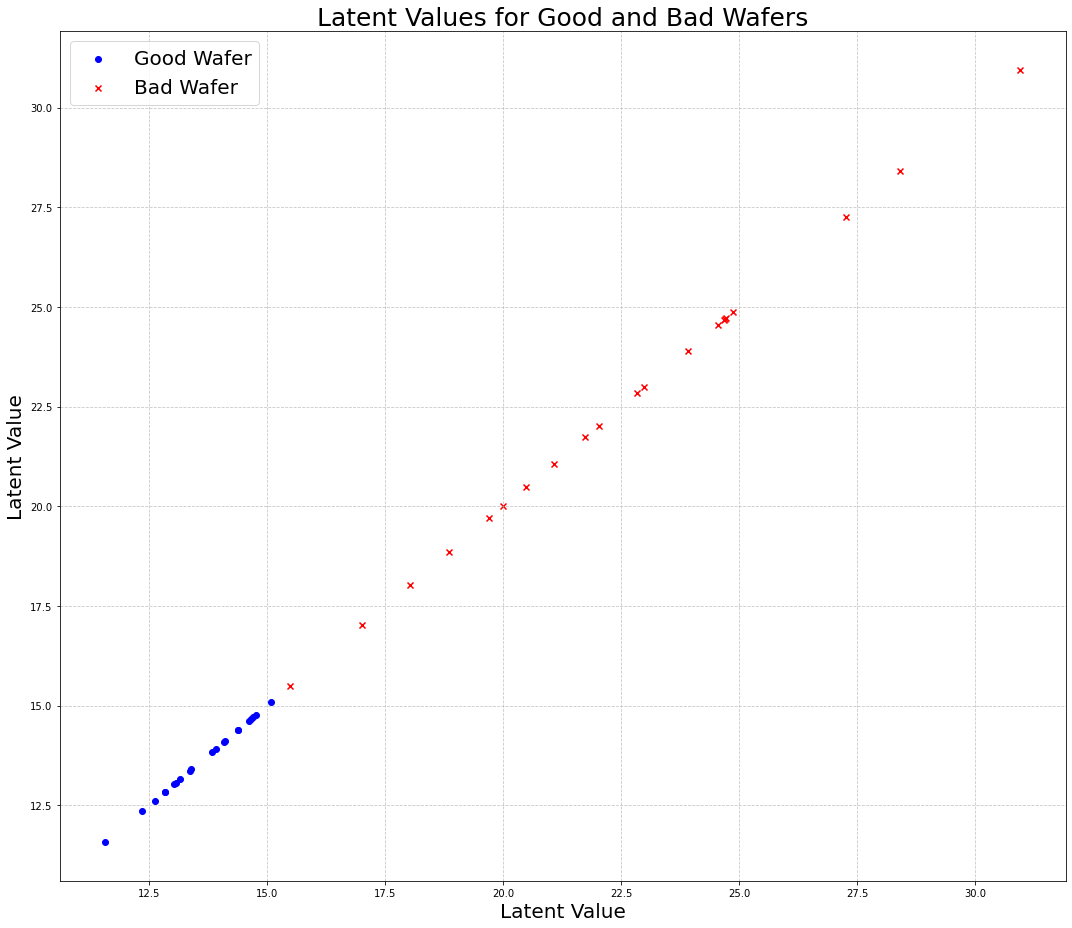


Confusion Matrix:
                                         Actual Good Wafer    Actual Bad Wafer    
Predicted Good Wafer                     20                   1                   
Predicted Bad Wafer                      1                    20                  


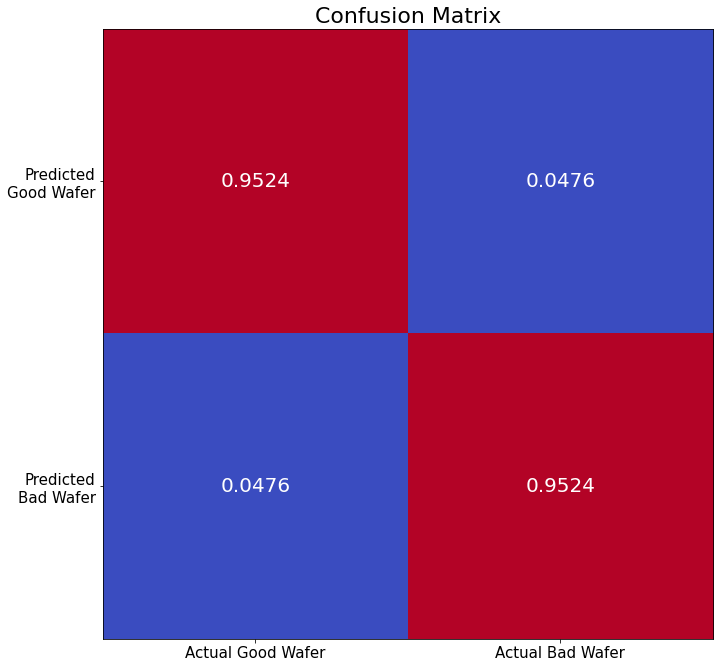

In [24]:
actualbad = resulttb[0:21]
actualgood = resulttb[21:42]

plot_latent(actualgood,actualbad)

latent_predicted_bad_wafer_data = resulttb[0:21]
latent_predicted_good_wafer_data = resulttb[21:42]

threshold_lower = good_mean - 2 * good_std
threshold_upper = good_mean + 2 * good_std

good_wafer_good_detection, good_wafer_bad_detection = classify(latent_predicted_good_wafer_data, threshold_lower, threshold_upper)
bad_wafer_good_detection, bad_wafer_bad_detection = classify(latent_predicted_bad_wafer_data, threshold_lower, threshold_upper)

total_bad_testing_data = len(latent_predicted_bad_wafer_data)
total_good_testing_data = len(latent_predicted_good_wafer_data)

table = np.array([
    ["",    "Actual Good Wafer", "Actual Bad Wafer"],
    ["Predicted Good Wafer", good_wafer_good_detection, bad_wafer_good_detection],
    ["Predicted Bad Wafer", good_wafer_bad_detection, bad_wafer_bad_detection]
])

# Display the table
print("\nConfusion Matrix:")
print("{:<40} {:<20} {:<20}".format(*table[0]))  # Header row
for row in table[1:]:
    print("{:<40} {:<20} {:<20}".format(*row))  # Data rows

confusion_matrix = np.array([
    [np.round(good_wafer_good_detection/total_good_testing_data,4), np.round(bad_wafer_good_detection/total_bad_testing_data,4)],  # Predicted Good: Actual Good, Actual Bad
    [np.round(good_wafer_bad_detection/total_good_testing_data,4), np.round(bad_wafer_bad_detection/total_bad_testing_data,4)]   # Predicted Bad: Actual Good, Actual Bad
])

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(confusion_matrix, cmap="coolwarm")

# Adding labels
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(["Actual Good Wafer", "Actual Bad Wafer"], fontsize=15)
ax.set_yticklabels(["Predicted\nGood Wafer", "Predicted\nBad Wafer"], fontsize=15)

# Rotating tick labels for better readability
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Adding text annotations with text wrapping
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(confusion_matrix[i, j]), ha="center", va="center", color="white", fontsize=20)

# Title and display
ax.set_title("Confusion Matrix", fontsize=22)
plt.tight_layout()
plt.show()

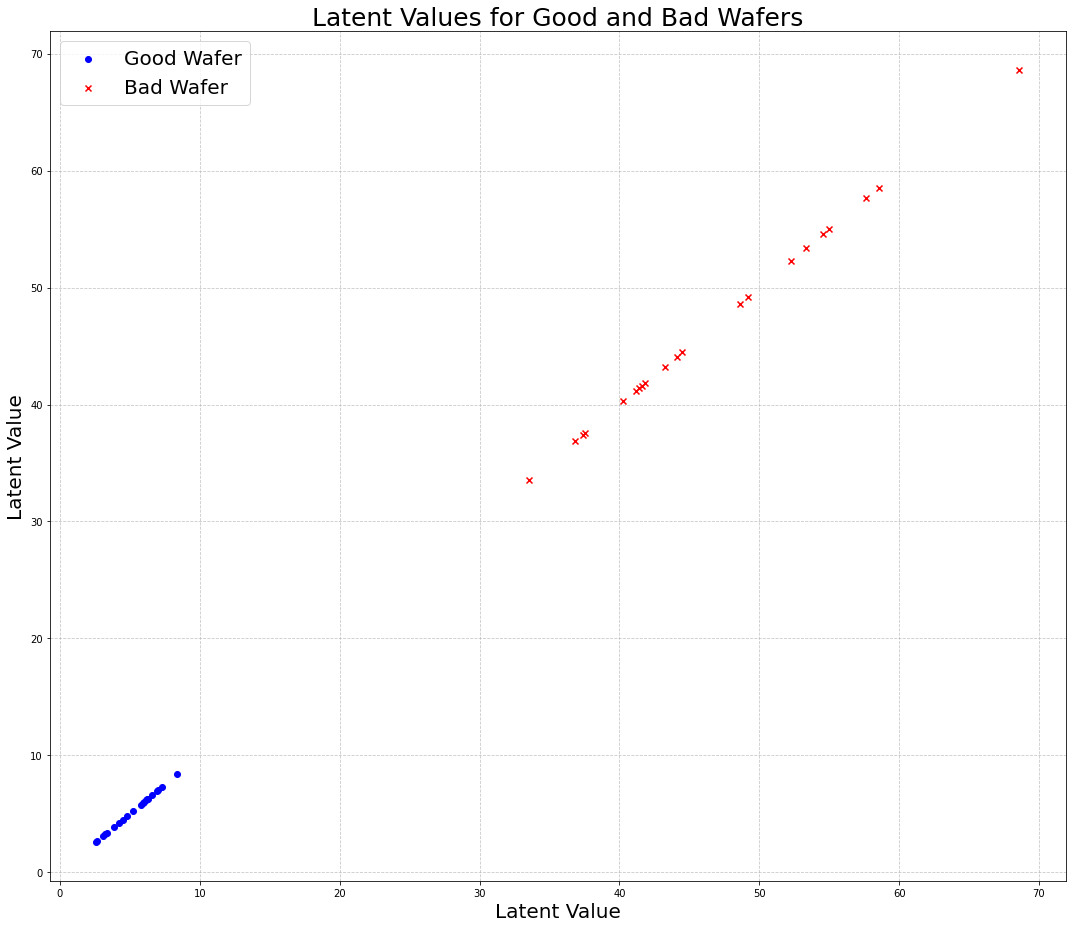

In [25]:
compare_bad = test_data(data_train[0:21])
compare_good = test_data(data_train[21:42])

# Plot latent values
plot_latent(compare_good, compare_bad)

In [26]:
max_shape = (40,40)
target_shape = (32,32)
train_max_row = 462 # Maximum data for training

strClass_trainTestLaebl_df = df[df['trainTestLabel'].apply(lambda x: isinstance(x, str))]
limited_df = sizeLimit_df(strClass_trainTestLaebl_df,max_shape,True)
training_df = limited_df[limited_df['trainTestLabel'] == 'Training']

bad_wafer_df = training_df[ (training_df['failureType'] != 'none')]
good_wafer_df = training_df[ (training_df['failureType'] == 'none')]

# Function to filter very bad data
def filter_condition(np_arr, wafer_type):
    count_0 = np.sum(np_arr == 0)  # Count occurrences of 1
    count_1 = np.sum(np_arr == 1)  # Count occurrences of 1
    count_2 = np.sum(np_arr == 2)  # Count occurrences of 2
    if wafer_type == 'bad': return (count_2 > 0.05 * count_1) & (count_0 < count_1)  # Check if count of 2 is less than 20% of count of 1
    else: return (count_2 < 0.05 * count_1) & (count_0 < count_1)  # Check if count of 2 is less than 20% of count of 1


bad_wafer_df = bad_wafer_df[bad_wafer_df['waferMap'].apply(lambda x: filter_condition(x, 'bad'))]
good_wafer_df = good_wafer_df[good_wafer_df['waferMap'].apply(lambda x: filter_condition(x, 'good'))]

# Label data for bad wafer
maxSize_bad_wafer = bad_wafer_df[(bad_wafer_df['waferMap'].apply(lambda x: x.shape == (35,36)))]
mtrx_label_bad_wafer = np.stack(maxSize_bad_wafer['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
mtrx_label_bad_wafer[(mtrx_label_bad_wafer == 1) | (mtrx_label_bad_wafer > 2)] = 2
base_bad_valid = np.array(mtrx_label_bad_wafer[0])
label_bad_wafer = np.tile(base_bad_valid,(train_max_row,1))

# Label data for good wafer
maxSize_good_wafer = good_wafer_df[(good_wafer_df['waferMap'].apply(lambda x: x.shape == (35,37)))]
mtrx_label_good_wafer = np.stack(maxSize_good_wafer['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
mtrx_label_good_wafer[mtrx_label_good_wafer >1] = 1
base_good_valid = np.array(mtrx_label_good_wafer[0])
label_good_wafer = np.tile(base_good_valid,(train_max_row,1))

# Maximum Data for Training
# print(bad_wafer_df.shape, good_wafer_df.shape)
max_training_good = good_wafer_df.shape[0]
max_training_bad = bad_wafer_df.shape[0]
print(max_training_good, max_training_bad)
bad_wafer_df = bad_wafer_df[:train_max_row]
good_wafer_df = good_wafer_df[:train_max_row]

print(len(good_wafer_df))
print(len(bad_wafer_df))
# Scale all image to asme dimension then flatten it to single row
data_bad_wafer = np.stack(bad_wafer_df['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
data_bad_wafer[data_bad_wafer>2] = 2

data_good_wafer = np.stack(good_wafer_df['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
data_good_wafer[data_good_wafer>2] = 2

label_train = np.concatenate((label_bad_wafer, label_good_wafer), axis=0)
data_train = np.concatenate((data_bad_wafer, data_good_wafer), axis=0)

label_train = np.where(label_train == 0, 0 , np.where(label_train == 1, 0.5, 1))
data_train = np.where(data_train == 0, 0 , np.where(data_train == 1, 0.5, 1))

print(label_train.shape)
print(data_train.shape)


106 8003
106
462
(924, 1024)
(568, 1024)


In [27]:
fnn1 = "..\\rtl_dev_teffandi\\input1.txt"
fnn2 = "..\\rtl_dev_teffandi\\input2.txt"
fnn3 = "..\\rtl_dev_teffandi\\input3.txt"
fnn4 = "..\\rtl_dev_teffandi\\input4.txt"


all_image_data_txt(data_train, fnn1, fnn2, fnn3, fnn4)

Good: 0
Bad: 42


c:\Users\fauza\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\fauza\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\fauza\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\fauza\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\fauza\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rco

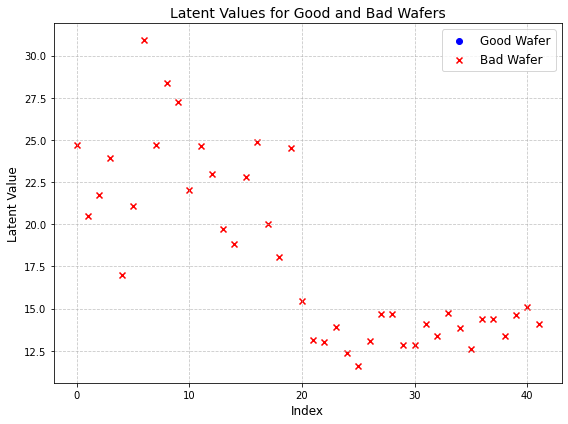

C:\Users\fauza\AppData\Local\Temp/ipykernel_31564/3045842396.py:67: RuntimeWarning: invalid value encountered in scalar divide
  [np.round(good_wafer_good_detection/total_good_testing_data,4), np.round(bad_wafer_good_detection/total_bad_testing_data,4)],  # Predicted Good: Actual Good, Actual Bad
C:\Users\fauza\AppData\Local\Temp/ipykernel_31564/3045842396.py:68: RuntimeWarning: invalid value encountered in scalar divide
  [np.round(good_wafer_bad_detection/total_good_testing_data,4), np.round(bad_wafer_bad_detection/total_bad_testing_data,4)]   # Predicted Bad: Actual Good, Actual Bad



Confusion Matrix:
                                         Actual Good Wafer    Actual Bad Wafer    
Predicted Good Wafer                     0                    0                   
Predicted Bad Wafer                      0                    42                  


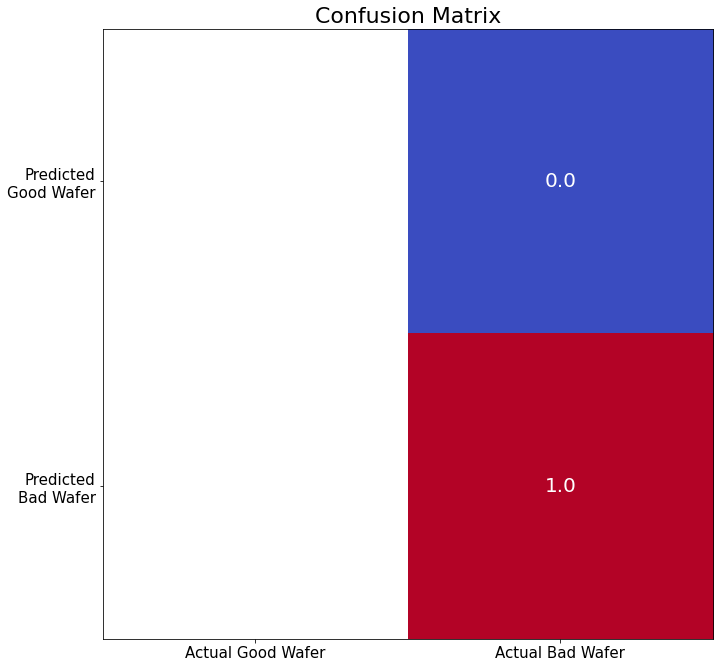

In [28]:
def plot_latent(good_latent,bad_latent):
    plt.figure(figsize=(8, 6))

    # Plot good wafers with 'o'
    plt.scatter(range(len(good_latent)), good_latent, marker='o', color='blue', label='Good Wafer')

    # Plot bad wafers with 'x'
    plt.scatter(range(len(bad_latent)), bad_latent, marker='x', color='red', label='Bad Wafer')

    # Adding labels, legend, and title
    plt.xlabel("Index", fontsize=12)
    plt.ylabel("Latent Value", fontsize=12)
    plt.title("Latent Values for Good and Bad Wafers", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Display the plot
    plt.tight_layout()
    plt.show()

result_tb = []
with open("data_tb\\result.txt", 'r') as file:
    for line in file:
        result_tb.append(fp_to_float(line.strip(),total_bits=16, frac_bits=8, input_format='hex'))
resulttb = np.array(result_tb)
# Compute mean and std for good wafer latent values
good_mean = np.mean(resulttb[462:568])
good_std = np.std(resulttb[462:568])

# Define thresholds
threshold_lower = good_mean - 2 * good_std
threshold_upper = good_mean + 2 * good_std
good, bad = classify(resulttb, threshold_lower, threshold_upper)
print("Good: " + str(good))
print("Bad: " + str(bad))

actualbad = resulttb[0:462]
actualgood = resulttb[462:568]

plot_latent(actualgood,actualbad)

latent_predicted_bad_wafer_data = resulttb[0:462]
latent_predicted_good_wafer_data = resulttb[462:568]

threshold_lower = good_mean - 2 * good_std
threshold_upper = good_mean + 2 * good_std

good_wafer_good_detection, good_wafer_bad_detection = classify(latent_predicted_good_wafer_data, threshold_lower, threshold_upper)
bad_wafer_good_detection, bad_wafer_bad_detection = classify(latent_predicted_bad_wafer_data, threshold_lower, threshold_upper)

total_bad_testing_data = len(latent_predicted_bad_wafer_data)
total_good_testing_data = len(latent_predicted_good_wafer_data)

table = np.array([
    ["",    "Actual Good Wafer", "Actual Bad Wafer"],
    ["Predicted Good Wafer", good_wafer_good_detection, bad_wafer_good_detection],
    ["Predicted Bad Wafer", good_wafer_bad_detection, bad_wafer_bad_detection]
])

# Display the table
print("\nConfusion Matrix:")
print("{:<40} {:<20} {:<20}".format(*table[0]))  # Header row
for row in table[1:]:
    print("{:<40} {:<20} {:<20}".format(*row))  # Data rows

confusion_matrix = np.array([
    [np.round(good_wafer_good_detection/total_good_testing_data,4), np.round(bad_wafer_good_detection/total_bad_testing_data,4)],  # Predicted Good: Actual Good, Actual Bad
    [np.round(good_wafer_bad_detection/total_good_testing_data,4), np.round(bad_wafer_bad_detection/total_bad_testing_data,4)]   # Predicted Bad: Actual Good, Actual Bad
])

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(confusion_matrix, cmap="coolwarm")

# Adding labels
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(["Actual Good Wafer", "Actual Bad Wafer"], fontsize=15)
ax.set_yticklabels(["Predicted\nGood Wafer", "Predicted\nBad Wafer"], fontsize=15)

# Rotating tick labels for better readability
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Adding text annotations with text wrapping
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(confusion_matrix[i, j]), ha="center", va="center", color="white", fontsize=20)

# Title and display
ax.set_title("Confusion Matrix", fontsize=22)
plt.tight_layout()
plt.show()

In [29]:
# Testing Mean and Variance
def test_mean_variance(data_to_test):
    tested_mean = []
    tested_var = []
    for x in data_to_test:
        x = x.reshape(1, -1)
        _, miu, var, _, _, _ = vae.forward(x)
        tested_mean.append(miu)
        tested_var.append(var)
    return tested_mean, tested_var

test = [];
#k = 0
#for i in range(32*k):
#    test.append(0)
#for i in range(32):
#    test.append(1)
#for i in range(1024-32*(k+1)):
#    test.append(0)
for i in range(1024):
    test.append(1)
test1 = np.array([test])
print(test1)

_, mean, var, _, _, _ = vae.forward(test1)
print(mean)
print(var)

print("OutMean:")
print(float_to_fp(mean[0][0], total_bits=16, frac_bits=8, output_format='hex'))
print("OutVar:")
print(float_to_fp(var[0][0], total_bits=16, frac_bits=8, output_format='hex'))

_, _, W_mu, B_mu, W_var, B_var, _, _, _, _ = vae.get_train_param()
print("Bias:")
print(B_var[0][0])
print(float_to_fp(B_var[0][0], total_bits=16, frac_bits=8, output_format='hex'))
print("Mean:")
print(W_var[32][0])
#for i in range(len(W_var)):
#    print(float_to_fp(W_var[i][0], total_bits=16, frac_bits=8, output_format='hex'))

fn1 = "..\\rtl_dev_teffandi\\input_bad1.txt"
fn2 = "..\\rtl_dev_teffandi\\input_bad2.txt"
fn3 = "..\\rtl_dev_teffandi\\input_bad3.txt"
fn4 = "..\\rtl_dev_teffandi\\input_bad4.txt"

np_arr = test1[0]
db_np_arr = [np_arr, np_arr]
all_image_data_txt(db_np_arr, fn1, fn2, fn3, fn4)

print(float_to_fp(np.dot(test1, W_var)[0][0], total_bits=16, frac_bits=8, output_format='hex'))
print("Test dari PE0-3 CH1, cycle 8")
f = 896
a = np.dot([test1[0][f:f+8]], W_var[f:f+8])[0][0]
b = np.dot([test1[0][f+8:f+16]], W_var[f+8:f+16])[0][0]
c = np.dot([test1[0][f+16:f+24]], W_var[f+16:f+24])[0][0]
d = np.dot([test1[0][f+24:f+32]], W_var[f+24:f+32])[0][0]

print(float_to_fp(a, total_bits=16, frac_bits=8, output_format='hex'))


print(float_to_fp(b, total_bits=16, frac_bits=8, output_format='hex'))
print(float_to_fp(c, total_bits=16, frac_bits=8, output_format='hex'))
print(float_to_fp(d, total_bits=16, frac_bits=8, output_format='hex'))
print("Out PE:")
print(float_to_fp(a+b+c+d, total_bits=16, frac_bits=8, output_format='hex'))
print("Out Array:")
print(float_to_fp(a+b+c+d+B_var[0][0], total_bits=16, frac_bits=8, output_format='hex'))

[[1 1 1 ... 1 1 1]]
[[74.14637021]]
[[-30.31325114]]
OutMean:
4a25
OutVar:
e1b0
Bias:
-0.06974362457699942
ffee
Mean:
-0.006644380858298882
e1c2
Test dari PE0-3 CH1, cycle 8
ffe4
ffbd
ffbd
ffe4
Out PE:
ff43
Out Array:
ff31


In [30]:
print(test1[0][0:8][0])
i = 8
print(float_to_fp(W_var[i-1:i][0][0], total_bits=16, frac_bits=8, output_format='hex'))

1
0003


In [31]:
for i in range(len(W_var)):
    print(float_to_fp(W_var[i][0], total_bits=16, frac_bits=8, output_format='hex'))


ffff
fffe
0000
ffff
fffc
0003
0002
0003
ffff
0002
0007
0002
fffa
fffb
fff5
fff5
fff6
fff3
fffb
fffd
fffe
0002
0002
0001
fffe
0001
ffff
0001
fffe
0001
ffff
0000
fffe
fffe
0002
fffd
ffff
0002
ffff
0001
fffd
fff6
fff8
fffa
fff7
fff4
fffa
fff8
fff6
fff7
fff7
fff3
fff2
fff7
fffa
ffff
fffb
ffff
0004
fffc
0000
fffe
fffc
0002
0001
0000
fffc
fffe
0002
fffb
ffff
fffe
fffc
fff5
fffb
fff6
fff9
fff5
fff7
fff7
fff1
fff8
fff8
fffa
fff2
fff2
fff7
fffa
fffe
0002
0000
0004
0002
0001
0000
fffc
ffff
0001
fffc
0002
0001
0000
fffc
fff3
fffe
fff8
fff6
fff8
fff4
fff4
fffc
fff8
fff5
fff6
fff6
fff9
fff7
fff8
fff9
fff8
ffed
fff4
fffc
0001
0003
ffff
0000
0002
0004
0000
0003
0005
fffc
fff6
fff9
fff9
fff3
fffa
fffd
fff6
fff9
fff6
fff5
fff9
fff8
fff5
fff6
fff9
fff8
fff4
fff5
fff4
fff6
fff4
fff6
0002
0005
fffc
ffff
0000
fffa
0000
ffff
fffc
fff6
fff5
fff2
fff6
fff7
fff2
fff9
fff5
fff8
fff9
fff1
fffa
fff4
fffa
fff6
fff6
fff9
fffb
fff5
fffa
fffa
fffb
fffa
0000
0003
0003
ffff
fffe
fffe
ffff
0001
fff6
fff2
fff3
fff4
fff7


In [32]:
print(float_to_fp(np.dot([test1[0][6:8]], W_var[6:8])[0][0], total_bits=16, frac_bits=8, output_format='hex'))
j = 7
x = np.dot([test1[0][j-1:j+128]], W_var[j-1:j+128])[0][0]
y1 = np.dot([test1[0][j-1:j]], W_var[j-1:j])[0][0]
y2 = np.dot([test1[0][j:j+1]], W_var[j:j+1])[0][0]
print(y1)
print(float_to_fp(y1, total_bits=16, frac_bits=8, output_format='hex'))
print(y2)
print(float_to_fp(y2, total_bits=16, frac_bits=8, output_format='hex'))
print(y1+y2)
print(float_to_fp(y1+y2, total_bits=16, frac_bits=8, output_format='hex'))

print("Loop:")
for k in range(8):
    x1 = np.dot([test1[0][(k)*128:(k+1)*128]], W_var[(k)*128:(k+1)*128])[0][0]
    print(x1)
    print(float_to_fp(x1, total_bits=16, frac_bits=8, output_format='hex'))

0006
0.008819578692456422
0002
0.013636206668932059
0003
0.02245578536138848
0006
Loop:
-2.09614519592231
fde7
-3.59306837297296
fc68
-4.58523282888462
fb6a
-4.967752156324703
fb08
-4.781398523865537
fb38
-4.211476158110269
fbca
-3.7457278884324516
fc41
-2.262706389659546
fdbd
